### Cab-Driver Agent

In [1]:
# install tqdm

!pip3 install tqdm

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3254, in <module>
    @_call_aside
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3238, in _call_aside
    f(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 3267, in _initialize_master_working_set
    working_set = WorkingSet._build_master()
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 584, in _build_master
    ws.require(__requires__)
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 901, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/usr/local/lib/python3.7/site-packages/pkg_resources/__init__.py", line 787, in resolve
    raise DistributionNotFound(req, requirers)
pkg_resources.DistributionNotFound

In [2]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Nadam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver
from tqdm import tqdm

Using TensorFlow backend.


#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
import pandas as pd
def convert_to_data_frame(model_name, data):
    df = pd.DataFrame.from_records(data)
    df['name'] = model_name
    return df

In [38]:
def plot_tracked_values(states_tracks, big=False, limit_values_from_last=None):
    if big:
        row = 2
        column = 2
        figsize = (16, 12)
    else:
        row = 1
        column = 4
        figsize = (16, 4)

    fig, axs = plt.subplots(row, column, figsize=figsize)
    
    for index, tracked_value in enumerate(tracked_values):
        if limit_values_from_last:
            item_to_select = min(
                len(states_tracks[tracked_value[0]][tracked_value[1]]),
                limit_values_from_last)

        else:
            item_to_select = len(
                states_tracks[tracked_value[0]][tracked_value[1]])

        xaxis = np.asarray(range(0, item_to_select))
        plt.subplot(row, column, index + 1)
        plt.plot(
            xaxis,
            np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]
                       [-item_to_select:]),)

        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
        plt.ylabel('Q values')
    plt.show()

In [9]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [10]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [11]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [12]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Nadam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [13]:
env = CabDriver()

In [14]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

### DQN block

In [15]:
def q_learning(agent_param,
               max_epsilon=1.0,
               episodes=50000,
               verbose=False,
               name='dqn_agent_state_as_input_arch'):

    log_threshold = episodes * .001
    threshold = episodes * .001
    model_threshold = episodes * 0.01

    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("model_threshold", model_threshold)

    start_time = time.time()

    agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

    total_rewards = []
    for episode in tqdm(range(episodes), ascii=True, unit='episodes'):

        # tracking total rewards, step count
        total_reward = 0

        state = env.reset()[2]
        is_finished = False

        current_episode = episode + 1

        while not is_finished:

            action = agent.get_action(state, episode, env.get_requests(state))

            reward = env.get_reward(state, action, Time_matrix)

            next_state, is_finished, episode_time_till_now = env.get_next_state(
                state, action, Time_matrix)

            agent.save_experience(state, action, reward, next_state,
                                  is_finished)

            # every time step do the training
            agent.train_model()
            total_reward += reward
            state = next_state

            # Store the rewards
            if is_finished and current_episode % log_threshold == 0:
                total_rewards.append(total_reward)
                if verbose:
                    print(
                        "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                        .format(current_episode, total_reward,
                                agent.memory_length(), episode_time_till_now,
                                agent.epsilon))

        if (current_episode % model_threshold) == 0:
            print("saving model for episode ", current_episode)
            agent.save("./" + name + "_dqn_cab_driver.h5")

        if (current_episode % threshold) == 0:
            agent.update_tracking_states()

    elapsed_time = time.time() - start_time
    print("elapsed_time {} minutes".format(round(elapsed_time / 60, 2)))

    return agent, total_rewards

In [16]:
stats = None

In [17]:
def collect_stats(df):
    global stats
    if stats is not None:
        stats = pd.concat([stats, df], axis=0)
    else:
        stats = df
    return df

In [18]:
EPISODES = 20000
agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0003,
    "discount_factor": 0.95,
    "batch_size": 64,
    "layers": [512, 256],
    "learning_rate": 0.001
}

agent_param = AgentParam(agent_param_dict)

agent, total_rewards = q_learning(agent_param=agent_param,
                                  episodes=EPISODES,
                                  verbose=True,
                                  name="dqn_agent_state_as_input_arch_32_32_2")

  0%|          | 0/20000 [00:00<?, ?episodes/s]

number of episodes 20000
log_threshold 20.0
threshold 20.0
model_threshold 200.0
Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0003
discount_factor -> 0.95
batch_size -> 64
layers -> [512, 256]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               18944     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
den

  0%|          | 20/20000 [00:27<7:27:46,  1.34s/episodes]

episode: 20, rewards: -311.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9943162198622191


  0%|          | 40/20000 [01:01<10:23:55,  1.88s/episodes]

episode: 40, rewards: -163.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.988368190475284


  0%|          | 60/20000 [01:39<9:20:43,  1.69s/episodes] 

episode: 60, rewards: -261.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.9824557424139498


  0%|          | 80/20000 [02:10<9:19:11,  1.68s/episodes]

episode: 80, rewards: -290.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9765786628294478


  0%|          | 100/20000 [02:44<9:26:54,  1.71s/episodes]

episode: 100, rewards: -379.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9707367401462782


  1%|          | 120/20000 [03:19<9:04:21,  1.64s/episodes] 

episode: 120, rewards: -63.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9649297640545934


  1%|          | 140/20000 [03:52<9:49:12,  1.78s/episodes]

episode: 140, rewards: -216.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.959157525502627


  1%|          | 160/20000 [04:27<9:30:39,  1.73s/episodes] 

episode: 160, rewards: -291.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.9534198166891678


  1%|          | 180/20000 [05:01<9:12:21,  1.67s/episodes]

episode: 180, rewards: -122.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.9477164310560786


  1%|1         | 200/20000 [05:33<8:28:59,  1.54s/episodes]

episode: 200, rewards: -237.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.9420471632808609
saving model for episode  200


  1%|1         | 220/20000 [06:08<9:34:57,  1.74s/episodes] 

episode: 220, rewards: -208.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9364118092692625


  1%|1         | 240/20000 [06:43<9:32:17,  1.74s/episodes] 

episode: 240, rewards: -368.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.9308101661479301


  1%|1         | 260/20000 [07:17<8:49:55,  1.61s/episodes] 

episode: 260, rewards: -173.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.9252420322571068


  1%|1         | 280/20000 [07:50<9:07:33,  1.67s/episodes]

episode: 280, rewards: -362.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9197072071433706


  2%|1         | 300/20000 [08:23<8:44:24,  1.60s/episodes]

episode: 300, rewards: -270.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9142054915524201


  2%|1         | 320/20000 [08:56<9:10:54,  1.68s/episodes]

episode: 320, rewards: -91.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9087366874218997


  2%|1         | 340/20000 [09:31<9:43:01,  1.78s/episodes] 

episode: 340, rewards: 139.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.9033005978742701


  2%|1         | 360/20000 [10:05<8:49:38,  1.62s/episodes] 

episode: 360, rewards: -60.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.8978970272097203


  2%|1         | 380/20000 [10:38<8:39:17,  1.59s/episodes]

episode: 380, rewards: -190.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.892525780899123


  2%|2         | 400/20000 [11:09<9:08:06,  1.68s/episodes]

episode: 400, rewards: -234.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.8871866655770311
saving model for episode  400


  2%|2         | 420/20000 [11:42<8:50:42,  1.63s/episodes]

episode: 420, rewards: -294.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.8818794890347158


  2%|2         | 440/20000 [12:16<9:30:21,  1.75s/episodes]

episode: 440, rewards: 79.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.8766040602132489


  2%|2         | 460/20000 [12:48<9:03:51,  1.67s/episodes]

episode: 460, rewards: -118.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.871360189196623


  2%|2         | 480/20000 [13:20<9:13:17,  1.70s/episodes]

episode: 480, rewards: -467.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.8661476872049149


  2%|2         | 500/20000 [13:53<8:36:15,  1.59s/episodes]

episode: 500, rewards: -345.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.8609663665874903


  3%|2         | 520/20000 [14:27<9:56:31,  1.84s/episodes]

episode: 520, rewards: -42.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.855816040816247


  3%|2         | 540/20000 [14:58<8:26:10,  1.56s/episodes]

episode: 540, rewards: -95.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.8506965244789013


  3%|2         | 560/20000 [15:31<8:48:19,  1.63s/episodes]

episode: 560, rewards: -118.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.8456076332723121


  3%|2         | 580/20000 [16:03<8:27:15,  1.57s/episodes]

episode: 580, rewards: -111.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.8405491839958464


  3%|3         | 600/20000 [16:32<7:38:09,  1.42s/episodes]

episode: 600, rewards: -321.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.8355209945447839
saving model for episode  600


  3%|3         | 620/20000 [17:02<7:57:16,  1.48s/episodes]

episode: 620, rewards: -165.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.8305228839037612


  3%|3         | 640/20000 [17:32<8:37:23,  1.60s/episodes]

episode: 640, rewards: -228.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.8255546721402555


  3%|3         | 660/20000 [18:01<7:51:56,  1.46s/episodes]

episode: 660, rewards: 88.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.8206161803981067


  3%|3         | 680/20000 [18:31<7:55:42,  1.48s/episodes]

episode: 680, rewards: -227.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.8157072308910789


  4%|3         | 700/20000 [19:01<7:39:54,  1.43s/episodes]

episode: 700, rewards: -239.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.8108276468964595


  4%|3         | 720/20000 [19:29<7:26:47,  1.39s/episodes]

episode: 720, rewards: -276.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.8059772527486977


  4%|3         | 740/20000 [19:58<7:37:21,  1.42s/episodes]

episode: 740, rewards: -24.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.8011558738330804


  4%|3         | 760/20000 [20:28<7:54:32,  1.48s/episodes]

episode: 760, rewards: 56.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.7963633365794459


  4%|3         | 780/20000 [20:56<7:50:56,  1.47s/episodes]

episode: 780, rewards: -309.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.7915994684559357


  4%|4         | 800/20000 [21:26<8:12:11,  1.54s/episodes]

episode: 800, rewards: -217.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.7868640979627824
saving model for episode  800


  4%|4         | 820/20000 [21:55<7:52:15,  1.48s/episodes]

episode: 820, rewards: -6.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.7821570546261372


  4%|4         | 840/20000 [22:23<7:35:36,  1.43s/episodes]

episode: 840, rewards: -129.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.7774781689919315


  4%|4         | 860/20000 [22:53<7:54:32,  1.49s/episodes]

episode: 860, rewards: -316.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.7728272726197771


  4%|4         | 880/20000 [23:22<7:27:44,  1.41s/episodes]

episode: 880, rewards: -1.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.7682041980769023


  4%|4         | 900/20000 [23:51<7:47:32,  1.47s/episodes]

episode: 900, rewards: -405.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.7636087789321244


  5%|4         | 920/20000 [24:21<8:20:21,  1.57s/episodes]

episode: 920, rewards: -315.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.7590408497498577


  5%|4         | 940/20000 [24:50<7:17:00,  1.38s/episodes]

episode: 940, rewards: -119.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.7545002460841587


  5%|4         | 960/20000 [25:18<7:28:21,  1.41s/episodes]

episode: 960, rewards: -52.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.7499868044728044


  5%|4         | 980/20000 [25:46<7:29:54,  1.42s/episodes]

episode: 980, rewards: 80.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.7455003624314098


  5%|5         | 1000/20000 [26:15<7:18:29,  1.38s/episodes]

episode: 1000, rewards: 197.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.7410407584475768
saving model for episode  1000


  5%|5         | 1020/20000 [26:43<7:06:05,  1.35s/episodes]

episode: 1020, rewards: -113.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.7366078319750803


  5%|5         | 1040/20000 [27:12<7:47:44,  1.48s/episodes]

episode: 1040, rewards: 108.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.7322014234280885


  5%|5         | 1060/20000 [27:40<7:36:39,  1.45s/episodes]

episode: 1060, rewards: -459.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.7278213741754178


  5%|5         | 1080/20000 [28:08<7:43:08,  1.47s/episodes]

episode: 1080, rewards: -54.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.7234675265348222


  6%|5         | 1100/20000 [28:37<7:24:26,  1.41s/episodes]

episode: 1100, rewards: 9.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.7191397237673163


  6%|5         | 1120/20000 [29:06<7:44:36,  1.48s/episodes]

episode: 1120, rewards: -325.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.714837810071533


  6%|5         | 1140/20000 [29:36<7:25:34,  1.42s/episodes]

episode: 1140, rewards: -192.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.7105616305781148


  6%|5         | 1160/20000 [30:04<7:08:50,  1.37s/episodes]

episode: 1160, rewards: -363.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.7063110313441382


  6%|5         | 1180/20000 [30:32<7:22:32,  1.41s/episodes]

episode: 1180, rewards: -122.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.7020858593475715


  6%|6         | 1200/20000 [31:01<7:25:28,  1.42s/episodes]

episode: 1200, rewards: -302.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6978859624817665
saving model for episode  1200


  6%|6         | 1220/20000 [31:30<7:03:06,  1.35s/episodes]

episode: 1220, rewards: -353.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.6937111895499825


  6%|6         | 1240/20000 [31:58<7:12:59,  1.38s/episodes]

episode: 1240, rewards: -237.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.6895613902599432


  6%|6         | 1260/20000 [32:28<7:04:40,  1.36s/episodes]

episode: 1260, rewards: -107.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.6854364152184258


  6%|6         | 1280/20000 [32:56<7:17:09,  1.40s/episodes]

episode: 1280, rewards: -5.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6813361159258833


  6%|6         | 1300/20000 [33:25<7:30:10,  1.44s/episodes]

episode: 1300, rewards: -198.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6772603447710984


  7%|6         | 1320/20000 [33:53<7:26:39,  1.43s/episodes]

episode: 1320, rewards: -135.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6732089550258695


  7%|6         | 1340/20000 [34:22<7:44:56,  1.49s/episodes]

episode: 1340, rewards: -146.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6691818008397281


  7%|6         | 1360/20000 [34:50<7:09:24,  1.38s/episodes]

episode: 1360, rewards: -117.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.6651787372346883


  7%|6         | 1380/20000 [35:20<8:04:17,  1.56s/episodes]

episode: 1380, rewards: -36.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6611996201000285


  7%|7         | 1400/20000 [35:48<7:08:08,  1.38s/episodes]

episode: 1400, rewards: -81.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6572443061871017
saving model for episode  1400


  7%|7         | 1420/20000 [36:17<7:24:34,  1.44s/episodes]

episode: 1420, rewards: -186.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.65331265310418


  7%|7         | 1440/20000 [36:44<7:11:48,  1.40s/episodes]

episode: 1440, rewards: -270.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6494045193113278


  7%|7         | 1460/20000 [37:11<7:17:32,  1.42s/episodes]

episode: 1460, rewards: 40.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.6455197641153065


  7%|7         | 1480/20000 [37:40<7:24:31,  1.44s/episodes]

episode: 1480, rewards: -185.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.6416582476645095


  8%|7         | 1500/20000 [38:07<7:13:09,  1.40s/episodes]

episode: 1500, rewards: -335.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.6378198309439275


  8%|7         | 1520/20000 [38:34<6:59:14,  1.36s/episodes]

episode: 1520, rewards: -74.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6340043757701439


  8%|7         | 1540/20000 [39:04<7:06:15,  1.39s/episodes]

episode: 1540, rewards: -117.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6302117447863606


  8%|7         | 1560/20000 [39:32<7:09:08,  1.40s/episodes]

episode: 1560, rewards: -248.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6264418014574522


  8%|7         | 1580/20000 [40:00<7:02:40,  1.38s/episodes]

episode: 1580, rewards: -32.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6226944100650522


  8%|8         | 1600/20000 [40:27<6:52:54,  1.35s/episodes]

episode: 1600, rewards: -199.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6189694357026654
saving model for episode  1600


  8%|8         | 1620/20000 [40:56<7:10:48,  1.41s/episodes]

episode: 1620, rewards: -382.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6152667442708126


  8%|8         | 1640/20000 [41:24<6:58:38,  1.37s/episodes]

episode: 1640, rewards: -171.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6115862024722023


  8%|8         | 1660/20000 [41:51<7:05:50,  1.39s/episodes]

episode: 1660, rewards: -154.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6079276778069324


  8%|8         | 1680/20000 [42:20<7:04:26,  1.39s/episodes]

episode: 1680, rewards: -243.0, replay_buffer_size: 2000, episode_time: 701.0, epsilon: 0.6042910385677196


  8%|8         | 1700/20000 [42:47<7:09:00,  1.41s/episodes]

episode: 1700, rewards: -138.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.6006761538351586


  9%|8         | 1720/20000 [43:16<7:06:37,  1.40s/episodes]

episode: 1720, rewards: -252.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5970828934730088


  9%|8         | 1740/20000 [43:44<6:56:00,  1.37s/episodes]

episode: 1740, rewards: 47.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5935111281235088


  9%|8         | 1760/20000 [44:11<6:49:38,  1.35s/episodes]

episode: 1760, rewards: 134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5899607292027206


  9%|8         | 1780/20000 [44:39<6:55:11,  1.37s/episodes]

episode: 1780, rewards: -86.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5864315688958992


  9%|9         | 1800/20000 [45:07<7:35:54,  1.50s/episodes]

episode: 1800, rewards: -266.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.5829235201528927
saving model for episode  1800


  9%|9         | 1820/20000 [45:34<6:18:10,  1.25s/episodes]

episode: 1820, rewards: -218.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.5794364566835675


  9%|9         | 1840/20000 [46:03<7:39:54,  1.52s/episodes]

episode: 1840, rewards: -270.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.575970252953262


  9%|9         | 1860/20000 [46:32<6:40:01,  1.32s/episodes]

episode: 1860, rewards: -150.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.5725247841782675


  9%|9         | 1880/20000 [47:00<7:31:43,  1.50s/episodes]

episode: 1880, rewards: -306.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5690999263213361


 10%|9         | 1900/20000 [47:29<6:53:52,  1.37s/episodes]

episode: 1900, rewards: -167.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.565695556087215


 10%|9         | 1920/20000 [47:57<7:01:31,  1.40s/episodes]

episode: 1920, rewards: -473.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.5623115509182082


 10%|9         | 1940/20000 [48:25<6:53:26,  1.37s/episodes]

episode: 1940, rewards: -231.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5589477889897639


 10%|9         | 1960/20000 [48:53<7:19:19,  1.46s/episodes]

episode: 1960, rewards: -221.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.5556041492060897


 10%|9         | 1980/20000 [49:21<7:05:38,  1.42s/episodes]

episode: 1980, rewards: -189.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5522805111957922


 10%|#         | 2000/20000 [49:47<6:45:50,  1.35s/episodes]

episode: 2000, rewards: 106.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.5489767553075439
saving model for episode  2000


 10%|#         | 2020/20000 [50:17<7:00:15,  1.40s/episodes]

episode: 2020, rewards: -18.0, replay_buffer_size: 2000, episode_time: 701.0, epsilon: 0.545692762605776


 10%|#         | 2040/20000 [50:44<6:25:07,  1.29s/episodes]

episode: 2040, rewards: -314.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5424284148663969


 10%|#         | 2060/20000 [51:10<6:28:25,  1.30s/episodes]

episode: 2060, rewards: -189.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5391835945725352


 10%|#         | 2080/20000 [51:38<6:48:07,  1.37s/episodes]

episode: 2080, rewards: 54.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5359581849103099


 10%|#         | 2100/20000 [52:06<7:05:03,  1.42s/episodes]

episode: 2100, rewards: -500.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.5327520697646247


 11%|#         | 2120/20000 [52:34<6:35:45,  1.33s/episodes]

episode: 2120, rewards: -128.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.5295651337149883


 11%|#         | 2140/20000 [53:00<6:52:13,  1.38s/episodes]

episode: 2140, rewards: -31.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5263972620313585


 11%|#         | 2160/20000 [53:28<6:53:59,  1.39s/episodes]

episode: 2160, rewards: -368.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5232483406700129


 11%|#         | 2180/20000 [53:55<6:45:31,  1.37s/episodes]

episode: 2180, rewards: 74.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5201182562694421


 11%|#1        | 2200/20000 [54:24<6:55:47,  1.40s/episodes]

episode: 2200, rewards: 31.0, replay_buffer_size: 2000, episode_time: 702.0, epsilon: 0.5170068961462697
saving model for episode  2200


 11%|#1        | 2220/20000 [54:50<6:59:35,  1.42s/episodes]

episode: 2220, rewards: -342.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.5139141482911953


 11%|#1        | 2240/20000 [55:19<7:09:45,  1.45s/episodes]

episode: 2240, rewards: -370.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.510839901364962


 11%|#1        | 2260/20000 [55:48<6:53:48,  1.40s/episodes]

episode: 2260, rewards: -181.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5077840446943486


 11%|#1        | 2280/20000 [56:15<6:41:58,  1.36s/episodes]

episode: 2280, rewards: -242.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5047464682681848


 12%|#1        | 2300/20000 [56:42<6:15:27,  1.27s/episodes]

episode: 2300, rewards: -248.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5017270627333913


 12%|#1        | 2320/20000 [57:10<6:44:22,  1.37s/episodes]

episode: 2320, rewards: 9.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.49872571939104254


 12%|#1        | 2340/20000 [57:38<6:46:24,  1.38s/episodes]

episode: 2340, rewards: -126.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4957423301924543


 12%|#1        | 2360/20000 [58:05<7:08:49,  1.46s/episodes]

episode: 2360, rewards: -48.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.49277678773529315


 12%|#1        | 2380/20000 [58:32<6:19:56,  1.29s/episodes]

episode: 2380, rewards: -118.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.48982898525971025


 12%|#2        | 2400/20000 [58:59<6:36:34,  1.35s/episodes]

episode: 2400, rewards: -107.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.4868988166444982
saving model for episode  2400


 12%|#2        | 2420/20000 [59:27<6:36:01,  1.35s/episodes]

episode: 2420, rewards: -68.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.48398617640327035


 12%|#2        | 2440/20000 [59:53<6:20:26,  1.30s/episodes]

episode: 2440, rewards: -288.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.4810909596806635


 12%|#2        | 2460/20000 [1:00:19<6:21:49,  1.31s/episodes]

episode: 2460, rewards: 265.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.47821306224856297


 12%|#2        | 2480/20000 [1:00:47<6:30:38,  1.34s/episodes]

episode: 2480, rewards: -77.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4753523805023503


 12%|#2        | 2500/20000 [1:01:15<6:42:21,  1.38s/episodes]

episode: 2500, rewards: -153.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4725088114571737


 13%|#2        | 2520/20000 [1:01:42<5:57:28,  1.23s/episodes]

episode: 2520, rewards: -99.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4696822527442405


 13%|#2        | 2540/20000 [1:02:08<7:00:29,  1.45s/episodes]

episode: 2540, rewards: 301.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.46687260260713176


 13%|#2        | 2560/20000 [1:02:37<6:43:53,  1.39s/episodes]

episode: 2560, rewards: 18.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.46407975989813904


 13%|#2        | 2580/20000 [1:03:04<6:43:37,  1.39s/episodes]

episode: 2580, rewards: -334.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4613036240746232


 13%|#3        | 2600/20000 [1:03:31<6:39:08,  1.38s/episodes]

episode: 2600, rewards: -35.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.45854409519539485
saving model for episode  2600


 13%|#3        | 2620/20000 [1:03:57<6:33:24,  1.36s/episodes]

episode: 2620, rewards: 52.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.4558010739171162


 13%|#3        | 2640/20000 [1:04:24<7:01:42,  1.46s/episodes]

episode: 2640, rewards: -261.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.45307446149072506


 13%|#3        | 2660/20000 [1:04:53<6:38:09,  1.38s/episodes]

episode: 2660, rewards: -75.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4503641597578796


 13%|#3        | 2680/20000 [1:05:20<6:30:39,  1.35s/episodes]

episode: 2680, rewards: -333.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.44767007114742463


 14%|#3        | 2700/20000 [1:05:49<7:27:16,  1.55s/episodes]

episode: 2700, rewards: -324.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.44499209867187933


 14%|#3        | 2720/20000 [1:06:19<6:58:33,  1.45s/episodes]

episode: 2720, rewards: -30.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.44233014592394526


 14%|#3        | 2740/20000 [1:06:46<6:22:51,  1.33s/episodes]

episode: 2740, rewards: -117.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4396841170730362


 14%|#3        | 2760/20000 [1:07:16<7:27:51,  1.56s/episodes]

episode: 2760, rewards: -108.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4370539168618275


 14%|#3        | 2780/20000 [1:07:44<6:40:50,  1.40s/episodes]

episode: 2780, rewards: -252.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.4344394506028276


 14%|#4        | 2800/20000 [1:08:12<6:49:26,  1.43s/episodes]

episode: 2800, rewards: -167.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.43184062417496877
saving model for episode  2800


 14%|#4        | 2820/20000 [1:08:39<6:09:02,  1.29s/episodes]

episode: 2820, rewards: -63.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.42925734402021903


 14%|#4        | 2840/20000 [1:09:05<6:43:36,  1.41s/episodes]

episode: 2840, rewards: 16.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.42668951714021375


 14%|#4        | 2860/20000 [1:09:34<6:54:06,  1.45s/episodes]

episode: 2860, rewards: -127.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.424137051092908


 14%|#4        | 2880/20000 [1:10:01<6:21:33,  1.34s/episodes]

episode: 2880, rewards: 142.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4215998539892482


 14%|#4        | 2900/20000 [1:10:30<6:39:29,  1.40s/episodes]

episode: 2900, rewards: -154.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.41907783448986485


 15%|#4        | 2920/20000 [1:10:57<6:34:15,  1.38s/episodes]

episode: 2920, rewards: 157.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.4165709018017834


 15%|#4        | 2940/20000 [1:11:25<6:24:25,  1.35s/episodes]

episode: 2940, rewards: -258.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.4140789656751565


 15%|#4        | 2960/20000 [1:11:59<10:47:42,  2.28s/episodes]

episode: 2960, rewards: -104.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.41160193640001436


 15%|#4        | 2980/20000 [1:12:43<8:39:21,  1.83s/episodes] 

episode: 2980, rewards: -36.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.40913972480303556


 15%|#5        | 3000/20000 [1:13:18<8:21:42,  1.77s/episodes]

episode: 3000, rewards: -87.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.4066922422443367
saving model for episode  3000


 15%|#5        | 3020/20000 [1:13:52<7:29:53,  1.59s/episodes]

episode: 3020, rewards: 55.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4042594006142814


 15%|#5        | 3040/20000 [1:14:21<6:31:49,  1.39s/episodes]

episode: 3040, rewards: -362.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4018411123303081


 15%|#5        | 3060/20000 [1:14:51<6:49:17,  1.45s/episodes]

episode: 3060, rewards: -137.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.3994372903337775


 15%|#5        | 3080/20000 [1:15:22<7:15:33,  1.54s/episodes]

episode: 3080, rewards: -18.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.39704784808683813


 16%|#5        | 3100/20000 [1:15:53<7:13:00,  1.54s/episodes]

episode: 3100, rewards: -62.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.39467269956931095


 16%|#5        | 3120/20000 [1:16:25<7:25:16,  1.58s/episodes]

episode: 3120, rewards: -263.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.39231175927559286


 16%|#5        | 3140/20000 [1:16:53<6:51:15,  1.46s/episodes]

episode: 3140, rewards: -145.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.38996494221157835


 16%|#5        | 3160/20000 [1:17:24<6:58:38,  1.49s/episodes]

episode: 3160, rewards: -90.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3876321638915996


 16%|#5        | 3180/20000 [1:17:54<6:53:41,  1.48s/episodes]

episode: 3180, rewards: -5.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.3853133403353851


 16%|#6        | 3200/20000 [1:18:26<7:28:04,  1.60s/episodes]

episode: 3200, rewards: 146.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.38300838806503645
saving model for episode  3200


 16%|#6        | 3220/20000 [1:18:56<6:50:18,  1.47s/episodes]

episode: 3220, rewards: -250.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.3807172241020231


 16%|#6        | 3240/20000 [1:19:31<9:23:08,  2.02s/episodes]

episode: 3240, rewards: 63.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.37843976596419476


 16%|#6        | 3260/20000 [1:20:07<7:56:24,  1.71s/episodes]

episode: 3260, rewards: 147.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.37617593166281255


 16%|#6        | 3280/20000 [1:20:38<7:10:59,  1.55s/episodes]

episode: 3280, rewards: -12.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.3739256396995972


 16%|#6        | 3300/20000 [1:21:11<7:48:28,  1.68s/episodes]

episode: 3300, rewards: -495.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.3716888090637948


 17%|#6        | 3320/20000 [1:21:43<7:35:41,  1.64s/episodes]

episode: 3320, rewards: -221.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.3694653592292612


 17%|#6        | 3340/20000 [1:22:17<7:35:07,  1.64s/episodes]

episode: 3340, rewards: -5.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.36725521015156204


 17%|#6        | 3360/20000 [1:22:50<7:35:06,  1.64s/episodes]

episode: 3360, rewards: 58.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.36505828226509174


 17%|#6        | 3380/20000 [1:23:25<7:33:32,  1.64s/episodes]

episode: 3380, rewards: -243.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3628744964802093


 17%|#7        | 3400/20000 [1:23:58<7:43:40,  1.68s/episodes]

episode: 3400, rewards: -12.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.36070377418039046
saving model for episode  3400


 17%|#7        | 3420/20000 [1:24:36<8:58:50,  1.95s/episodes]

episode: 3420, rewards: 62.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3585460372193981


 17%|#7        | 3440/20000 [1:25:11<7:26:52,  1.62s/episodes]

episode: 3440, rewards: 275.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.3564012079184685


 17%|#7        | 3460/20000 [1:25:41<6:32:24,  1.42s/episodes]

episode: 3460, rewards: -154.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.35426920906351533


 17%|#7        | 3480/20000 [1:26:14<7:59:24,  1.74s/episodes]

episode: 3480, rewards: -28.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.3521499639023494


 18%|#7        | 3500/20000 [1:26:49<7:45:38,  1.69s/episodes]

episode: 3500, rewards: 22.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.3500433961419161


 18%|#7        | 3520/20000 [1:27:21<7:09:41,  1.56s/episodes]

episode: 3520, rewards: -149.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.3479494299455485


 18%|#7        | 3540/20000 [1:27:50<6:22:08,  1.39s/episodes]

episode: 3540, rewards: 166.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.34586798993023743


 18%|#7        | 3560/20000 [1:28:21<7:38:19,  1.67s/episodes]

episode: 3560, rewards: 4.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.34379900116391754


 18%|#7        | 3580/20000 [1:28:53<7:27:16,  1.63s/episodes]

episode: 3580, rewards: 225.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3417423891627698


 18%|#8        | 3600/20000 [1:29:25<7:29:20,  1.64s/episodes]

episode: 3600, rewards: -117.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.33969807988854
saving model for episode  3600


 18%|#8        | 3620/20000 [1:29:54<6:33:46,  1.44s/episodes]

episode: 3620, rewards: 110.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3376659997458735


 18%|#8        | 3640/20000 [1:30:21<6:23:42,  1.41s/episodes]

episode: 3640, rewards: 117.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.33564607557966575


 18%|#8        | 3660/20000 [1:30:49<6:05:55,  1.34s/episodes]

episode: 3660, rewards: 159.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.3336382346724286


 18%|#8        | 3680/20000 [1:31:18<7:02:31,  1.55s/episodes]

episode: 3680, rewards: -72.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.33164240474167245


 18%|#8        | 3700/20000 [1:31:46<6:01:44,  1.33s/episodes]

episode: 3700, rewards: 0.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.32965851393730444


 19%|#8        | 3720/20000 [1:32:13<6:08:38,  1.36s/episodes]

episode: 3720, rewards: 216.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.3276864908390411


 19%|#8        | 3740/20000 [1:32:41<6:21:25,  1.41s/episodes]

episode: 3740, rewards: 287.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.3257262644538381


 19%|#8        | 3760/20000 [1:33:09<6:15:30,  1.39s/episodes]

episode: 3760, rewards: 174.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.3237777642133338


 19%|#8        | 3780/20000 [1:33:37<5:53:57,  1.31s/episodes]

episode: 3780, rewards: 117.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3218409199713091


 19%|#9        | 3800/20000 [1:34:04<6:15:14,  1.39s/episodes]

episode: 3800, rewards: 10.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3199156620011621
saving model for episode  3800


 19%|#9        | 3820/20000 [1:34:34<6:18:31,  1.40s/episodes]

episode: 3820, rewards: 396.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.318001920993398


 19%|#9        | 3840/20000 [1:35:01<6:11:23,  1.38s/episodes]

episode: 3840, rewards: 359.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.3160996280531338


 19%|#9        | 3860/20000 [1:35:30<6:23:08,  1.42s/episodes]

episode: 3860, rewards: 123.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3142087146976182


 19%|#9        | 3880/20000 [1:35:58<6:33:09,  1.46s/episodes]

episode: 3880, rewards: -133.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.31232911285376624


 20%|#9        | 3900/20000 [1:36:27<6:18:49,  1.41s/episodes]

episode: 3900, rewards: 90.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.31046075485570845


 20%|#9        | 3920/20000 [1:36:54<6:14:15,  1.40s/episodes]

episode: 3920, rewards: 360.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.3086035734423552


 20%|#9        | 3940/20000 [1:37:23<6:22:12,  1.43s/episodes]

episode: 3940, rewards: 121.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3067575017549749


 20%|#9        | 3960/20000 [1:37:51<6:16:53,  1.41s/episodes]

episode: 3960, rewards: 484.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.30492247333478756


 20%|#9        | 3980/20000 [1:38:19<6:01:28,  1.35s/episodes]

episode: 3980, rewards: 297.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.3030984221205718


 20%|##        | 4000/20000 [1:38:47<6:21:11,  1.43s/episodes]

episode: 4000, rewards: 99.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.301285282446287
saving model for episode  4000


 20%|##        | 4020/20000 [1:39:15<6:09:44,  1.39s/episodes]

episode: 4020, rewards: 494.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.299482989038709


 20%|##        | 4040/20000 [1:39:44<6:11:46,  1.40s/episodes]

episode: 4040, rewards: 153.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2976914770150805


 20%|##        | 4060/20000 [1:40:13<6:44:32,  1.52s/episodes]

episode: 4060, rewards: 447.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2959106818807752


 20%|##        | 4080/20000 [1:40:43<6:26:54,  1.46s/episodes]

episode: 4080, rewards: 365.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.29414053952697583


 20%|##        | 4100/20000 [1:41:12<6:30:16,  1.47s/episodes]

episode: 4100, rewards: 484.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2923809862283665


 21%|##        | 4120/20000 [1:41:42<6:09:36,  1.40s/episodes]

episode: 4120, rewards: 328.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.29063195864083846


 21%|##        | 4140/20000 [1:42:10<6:15:42,  1.42s/episodes]

episode: 4140, rewards: 117.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2888933937992097


 21%|##        | 4160/20000 [1:42:38<6:19:16,  1.44s/episodes]

episode: 4160, rewards: 331.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.2871652291149582


 21%|##        | 4180/20000 [1:43:06<6:33:57,  1.49s/episodes]

episode: 4180, rewards: 391.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.2854474023739685


 21%|##1       | 4200/20000 [1:43:36<6:50:42,  1.56s/episodes]

episode: 4200, rewards: 645.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2837398517342926
saving model for episode  4200


 21%|##1       | 4220/20000 [1:44:03<6:16:24,  1.43s/episodes]

episode: 4220, rewards: 445.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.2820425157239229


 21%|##1       | 4240/20000 [1:44:32<6:10:02,  1.41s/episodes]

episode: 4240, rewards: 94.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.28035533323857986


 21%|##1       | 4260/20000 [1:45:01<6:21:32,  1.45s/episodes]

episode: 4260, rewards: 335.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.2786782435395116


 21%|##1       | 4280/20000 [1:45:30<6:17:35,  1.44s/episodes]

episode: 4280, rewards: 383.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.277011186251308


 22%|##1       | 4300/20000 [1:45:58<6:01:18,  1.38s/episodes]

episode: 4300, rewards: 428.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2753541013597266


 22%|##1       | 4320/20000 [1:46:27<6:31:59,  1.50s/episodes]

episode: 4320, rewards: 515.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2737069292095323


 22%|##1       | 4340/20000 [1:46:56<5:51:00,  1.34s/episodes]

episode: 4340, rewards: 49.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.27206961050234985


 22%|##1       | 4360/20000 [1:47:26<6:50:43,  1.58s/episodes]

episode: 4360, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.27044208629452887


 22%|##1       | 4380/20000 [1:47:53<6:03:39,  1.40s/episodes]

episode: 4380, rewards: 369.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2688242979950222


 22%|##2       | 4400/20000 [1:48:23<6:19:22,  1.46s/episodes]

episode: 4400, rewards: 441.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.26721618736327635
saving model for episode  4400


 22%|##2       | 4420/20000 [1:48:53<6:18:01,  1.46s/episodes]

episode: 4420, rewards: 634.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2656176965071348


 22%|##2       | 4440/20000 [1:49:22<6:26:27,  1.49s/episodes]

episode: 4440, rewards: 333.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.26402876788075413


 22%|##2       | 4460/20000 [1:49:51<6:07:58,  1.42s/episodes]

episode: 4460, rewards: 819.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.26244934428253225


 22%|##2       | 4480/20000 [1:50:20<6:46:54,  1.57s/episodes]

episode: 4480, rewards: 1043.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.2608793688530489


 22%|##2       | 4500/20000 [1:50:50<5:44:24,  1.33s/episodes]

episode: 4500, rewards: 583.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2593187850730193


 23%|##2       | 4520/20000 [1:51:19<6:35:27,  1.53s/episodes]

episode: 4520, rewards: 371.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2577675367612586


 23%|##2       | 4540/20000 [1:51:48<5:50:20,  1.36s/episodes]

episode: 4540, rewards: 620.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.2562255680726601


 23%|##2       | 4560/20000 [1:52:19<6:48:21,  1.59s/episodes]

episode: 4560, rewards: 487.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.25469282349618455


 23%|##2       | 4580/20000 [1:52:48<5:47:58,  1.35s/episodes]

episode: 4580, rewards: 548.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.2531692478528616


 23%|##3       | 4600/20000 [1:53:16<6:28:13,  1.51s/episodes]

episode: 4600, rewards: 477.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.25165478629380356
saving model for episode  4600


 23%|##3       | 4620/20000 [1:53:45<5:55:04,  1.39s/episodes]

episode: 4620, rewards: 525.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2501493842982307


 23%|##3       | 4640/20000 [1:54:14<6:34:46,  1.54s/episodes]

episode: 4640, rewards: 432.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.24865298767150873


 23%|##3       | 4660/20000 [1:54:42<5:46:25,  1.35s/episodes]

episode: 4660, rewards: 491.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.2471655425431973


 23%|##3       | 4680/20000 [1:55:10<5:56:27,  1.40s/episodes]

episode: 4680, rewards: 535.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24568699536511127


 24%|##3       | 4700/20000 [1:55:40<6:30:59,  1.53s/episodes]

episode: 4700, rewards: 818.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24421729290939245


 24%|##3       | 4720/20000 [1:56:08<6:04:13,  1.43s/episodes]

episode: 4720, rewards: 391.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24275638226659382


 24%|##3       | 4740/20000 [1:56:39<6:07:49,  1.45s/episodes]

episode: 4740, rewards: 639.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24130421084377435


 24%|##3       | 4760/20000 [1:57:08<6:10:20,  1.46s/episodes]

episode: 4760, rewards: 716.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.23986072636260605


 24%|##3       | 4780/20000 [1:57:38<6:13:30,  1.47s/episodes]

episode: 4780, rewards: 549.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2384258768574917


 24%|##4       | 4800/20000 [1:58:06<6:04:16,  1.44s/episodes]

episode: 4800, rewards: 369.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2369996106736941
saving model for episode  4800


 24%|##4       | 4820/20000 [1:58:36<5:26:51,  1.29s/episodes]

episode: 4820, rewards: 652.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.2355818764654767


 24%|##4       | 4840/20000 [1:59:03<6:02:04,  1.43s/episodes]

episode: 4840, rewards: 904.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2341726231942548


 24%|##4       | 4860/20000 [1:59:34<5:56:32,  1.41s/episodes]

episode: 4860, rewards: 421.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.23277180012675847


 24%|##4       | 4880/20000 [2:00:03<6:40:01,  1.59s/episodes]

episode: 4880, rewards: 757.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.23137935683320593


 24%|##4       | 4900/20000 [2:00:33<6:22:35,  1.52s/episodes]

episode: 4900, rewards: 659.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2299952431854883


 25%|##4       | 4920/20000 [2:01:01<5:39:51,  1.35s/episodes]

episode: 4920, rewards: 688.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.22861940935536473


 25%|##4       | 4940/20000 [2:01:32<6:53:39,  1.65s/episodes]

episode: 4940, rewards: 1155.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.22725180581266882


 25%|##4       | 4960/20000 [2:02:01<6:13:29,  1.49s/episodes]

episode: 4960, rewards: 686.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.22589238332352524


 25%|##4       | 4980/20000 [2:02:31<6:05:10,  1.46s/episodes]

episode: 4980, rewards: 997.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.22454109294857763


 25%|##5       | 5000/20000 [2:02:58<6:02:08,  1.45s/episodes]

episode: 5000, rewards: 822.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.22319788604122653
saving model for episode  5000


 25%|##5       | 5020/20000 [2:03:28<6:33:46,  1.58s/episodes]

episode: 5020, rewards: 706.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.2218627142458782


 25%|##5       | 5040/20000 [2:04:00<6:35:19,  1.59s/episodes]

episode: 5040, rewards: 892.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2205355294962038


 25%|##5       | 5060/20000 [2:04:32<6:06:27,  1.47s/episodes]

episode: 5060, rewards: 699.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.21921628401340906


 25%|##5       | 5080/20000 [2:05:02<5:57:45,  1.44s/episodes]

episode: 5080, rewards: 675.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.21790493030451402


 26%|##5       | 5100/20000 [2:05:32<6:08:58,  1.49s/episodes]

episode: 5100, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.21660142116064365


 26%|##5       | 5120/20000 [2:06:01<6:15:42,  1.51s/episodes]

episode: 5120, rewards: 522.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.21530570965532791


 26%|##5       | 5140/20000 [2:06:32<6:22:33,  1.54s/episodes]

episode: 5140, rewards: 625.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.21401774914281269


 26%|##5       | 5160/20000 [2:07:01<5:40:41,  1.38s/episodes]

episode: 5160, rewards: 859.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.21273749325638047


 26%|##5       | 5180/20000 [2:07:34<6:32:25,  1.59s/episodes]

episode: 5180, rewards: 594.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.21146489590668108


 26%|##6       | 5200/20000 [2:08:04<6:06:04,  1.48s/episodes]

episode: 5200, rewards: 594.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.2101999112800724
saving model for episode  5200


 26%|##6       | 5220/20000 [2:08:34<6:25:51,  1.57s/episodes]

episode: 5220, rewards: 696.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.20894249383697133


 26%|##6       | 5240/20000 [2:09:04<5:56:53,  1.45s/episodes]

episode: 5240, rewards: 757.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2076925983102141


 26%|##6       | 5260/20000 [2:09:35<6:25:04,  1.57s/episodes]

episode: 5260, rewards: 908.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.20645017970342674


 26%|##6       | 5280/20000 [2:10:03<6:03:53,  1.48s/episodes]

episode: 5280, rewards: 959.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2052151932894053


 26%|##6       | 5300/20000 [2:10:33<6:06:35,  1.50s/episodes]

episode: 5300, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.2039875946085054


 27%|##6       | 5320/20000 [2:11:03<6:19:54,  1.55s/episodes]

episode: 5320, rewards: 663.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.20276733946704195


 27%|##6       | 5340/20000 [2:11:33<5:56:07,  1.46s/episodes]

episode: 5340, rewards: 732.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.20155438393569816


 27%|##6       | 5360/20000 [2:12:02<5:48:47,  1.43s/episodes]

episode: 5360, rewards: 921.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.20034868434794384


 27%|##6       | 5380/20000 [2:12:32<6:10:02,  1.52s/episodes]

episode: 5380, rewards: 899.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1991501972984636


 27%|##7       | 5400/20000 [2:13:03<6:09:23,  1.52s/episodes]

episode: 5400, rewards: 686.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.19795887964159425
saving model for episode  5400


 27%|##7       | 5420/20000 [2:13:33<6:02:10,  1.49s/episodes]

episode: 5420, rewards: 753.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.19677468848977148


 27%|##7       | 5440/20000 [2:14:02<6:01:47,  1.49s/episodes]

episode: 5440, rewards: 768.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.19559758121198592


 27%|##7       | 5460/20000 [2:14:33<5:51:42,  1.45s/episodes]

episode: 5460, rewards: 727.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.19442751543224843


 27%|##7       | 5480/20000 [2:15:02<6:20:19,  1.57s/episodes]

episode: 5480, rewards: 700.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.19326444902806464


 28%|##7       | 5500/20000 [2:15:32<6:16:50,  1.56s/episodes]

episode: 5500, rewards: 875.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.19210834012891828


 28%|##7       | 5520/20000 [2:16:02<6:23:08,  1.59s/episodes]

episode: 5520, rewards: 710.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.1909591471147642


 28%|##7       | 5540/20000 [2:16:33<6:17:37,  1.57s/episodes]

episode: 5540, rewards: 945.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.18981682861452978


 28%|##7       | 5560/20000 [2:17:02<5:24:26,  1.35s/episodes]

episode: 5560, rewards: 583.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1886813435046256


 28%|##7       | 5580/20000 [2:17:31<5:53:40,  1.47s/episodes]

episode: 5580, rewards: 876.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.18755265090746512


 28%|##8       | 5600/20000 [2:18:01<6:08:14,  1.53s/episodes]

episode: 5600, rewards: 903.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.18643071018999288
saving model for episode  5600


 28%|##8       | 5620/20000 [2:18:32<6:13:56,  1.56s/episodes]

episode: 5620, rewards: 657.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.18531548096222192


 28%|##8       | 5640/20000 [2:19:02<6:28:44,  1.62s/episodes]

episode: 5640, rewards: 792.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.18420692307577957


 28%|##8       | 5660/20000 [2:19:33<6:29:17,  1.63s/episodes]

episode: 5660, rewards: 819.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.1831049966224622


 28%|##8       | 5680/20000 [2:20:02<5:45:45,  1.45s/episodes]

episode: 5680, rewards: 638.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.18200966193279855


 28%|##8       | 5700/20000 [2:20:34<6:08:14,  1.55s/episodes]

episode: 5700, rewards: 1199.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.18092087957462138


 29%|##8       | 5720/20000 [2:21:04<6:27:38,  1.63s/episodes]

episode: 5720, rewards: 764.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.1798386103516483


 29%|##8       | 5740/20000 [2:21:33<5:52:33,  1.48s/episodes]

episode: 5740, rewards: 872.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.17876281530207036


 29%|##8       | 5760/20000 [2:22:04<6:32:13,  1.65s/episodes]

episode: 5760, rewards: 976.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.1776934556971496


 29%|##8       | 5780/20000 [2:22:34<5:38:18,  1.43s/episodes]

episode: 5780, rewards: 675.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.17663049303982473


 29%|##9       | 5800/20000 [2:23:01<5:29:01,  1.39s/episodes]

episode: 5800, rewards: 747.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1755738890633253
saving model for episode  5800


 29%|##9       | 5820/20000 [2:23:33<6:19:06,  1.60s/episodes]

episode: 5820, rewards: 875.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.17452360572979406


 29%|##9       | 5840/20000 [2:24:03<5:52:43,  1.49s/episodes]

episode: 5840, rewards: 794.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17347960522891753


 29%|##9       | 5860/20000 [2:24:33<5:50:56,  1.49s/episodes]

episode: 5860, rewards: 615.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.17244184997656498


 29%|##9       | 5880/20000 [2:25:05<6:19:39,  1.61s/episodes]

episode: 5880, rewards: 508.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.1714103026134352


 30%|##9       | 5900/20000 [2:25:36<6:26:27,  1.64s/episodes]

episode: 5900, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17038492600371175


 30%|##9       | 5920/20000 [2:26:07<6:14:48,  1.60s/episodes]

episode: 5920, rewards: 846.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.1693656832337259


 30%|##9       | 5940/20000 [2:26:38<6:20:18,  1.62s/episodes]

episode: 5940, rewards: 905.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1683525376106279


 30%|##9       | 5960/20000 [2:27:09<6:22:33,  1.63s/episodes]

episode: 5960, rewards: 561.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.16734545266106585


 30%|##9       | 5980/20000 [2:27:41<6:23:06,  1.64s/episodes]

episode: 5980, rewards: 970.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.16634439212987281


 30%|###       | 6000/20000 [2:28:11<6:03:09,  1.56s/episodes]

episode: 6000, rewards: 837.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.1653493199787616
saving model for episode  6000


 30%|###       | 6020/20000 [2:28:40<5:41:31,  1.47s/episodes]

episode: 6020, rewards: 760.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.16436020038502722


 30%|###       | 6040/20000 [2:29:12<7:27:26,  1.92s/episodes]

episode: 6040, rewards: 929.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.16337699774025752


 30%|###       | 6060/20000 [2:29:44<5:56:24,  1.53s/episodes]

episode: 6060, rewards: 803.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1623996766490511


 30%|###       | 6080/20000 [2:30:12<6:16:53,  1.62s/episodes]

episode: 6080, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.16142820192774313


 30%|###       | 6100/20000 [2:30:43<5:55:45,  1.54s/episodes]

episode: 6100, rewards: 1048.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.16046253860313872


 31%|###       | 6120/20000 [2:31:13<5:56:28,  1.54s/episodes]

episode: 6120, rewards: 666.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1595026519112539


 31%|###       | 6140/20000 [2:31:44<6:14:09,  1.62s/episodes]

episode: 6140, rewards: 765.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.15854850729606407


 31%|###       | 6160/20000 [2:32:13<5:58:59,  1.56s/episodes]

episode: 6160, rewards: 790.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.15760007040826007


 31%|###       | 6180/20000 [2:32:45<6:10:27,  1.61s/episodes]

episode: 6180, rewards: 876.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.15665730710401143


 31%|###1      | 6200/20000 [2:33:16<6:02:01,  1.57s/episodes]

episode: 6200, rewards: 959.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1557201834437375
saving model for episode  6200


 31%|###1      | 6220/20000 [2:33:48<6:30:29,  1.70s/episodes]

episode: 6220, rewards: 960.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.15478866569088523


 31%|###1      | 6240/20000 [2:34:21<6:45:45,  1.77s/episodes]

episode: 6240, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.15386272031071488


 31%|###1      | 6260/20000 [2:34:52<5:51:15,  1.53s/episodes]

episode: 6260, rewards: 1120.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.15294231396909283


 31%|###1      | 6280/20000 [2:35:24<6:10:45,  1.62s/episodes]

episode: 6280, rewards: 987.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.15202741353129134


 32%|###1      | 6300/20000 [2:35:55<6:02:59,  1.59s/episodes]

episode: 6300, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.15111798606079585


 32%|###1      | 6320/20000 [2:36:28<6:28:18,  1.70s/episodes]

episode: 6320, rewards: 896.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.15021399881811923


 32%|###1      | 6340/20000 [2:36:58<5:33:52,  1.47s/episodes]

episode: 6340, rewards: 883.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.14931541925962308


 32%|###1      | 6360/20000 [2:37:29<5:39:58,  1.50s/episodes]

episode: 6360, rewards: 805.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.14842221503634623


 32%|###1      | 6380/20000 [2:38:01<5:48:53,  1.54s/episodes]

episode: 6380, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1475343539928402


 32%|###2      | 6400/20000 [2:38:32<5:59:59,  1.59s/episodes]

episode: 6400, rewards: 1150.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.14665180416601153
saving model for episode  6400


 32%|###2      | 6420/20000 [2:39:03<5:41:45,  1.51s/episodes]

episode: 6420, rewards: 1169.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.14577453378397115


 32%|###2      | 6440/20000 [2:39:34<6:09:56,  1.64s/episodes]

episode: 6440, rewards: 738.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.14490251126489057


 32%|###2      | 6460/20000 [2:40:05<5:19:06,  1.41s/episodes]

episode: 6460, rewards: 551.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1440357052158649


 32%|###2      | 6480/20000 [2:40:38<5:39:05,  1.50s/episodes]

episode: 6480, rewards: 688.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.14317408443178273


 32%|###2      | 6500/20000 [2:41:08<5:19:30,  1.42s/episodes]

episode: 6500, rewards: 691.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.14231761789420286


 33%|###2      | 6520/20000 [2:41:40<5:58:03,  1.59s/episodes]

episode: 6520, rewards: 612.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.14146627477023738


 33%|###2      | 6540/20000 [2:42:10<5:27:31,  1.46s/episodes]

episode: 6540, rewards: 963.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1406200244114419


 33%|###2      | 6560/20000 [2:42:41<5:29:54,  1.47s/episodes]

episode: 6560, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.13977883635271207


 33%|###2      | 6580/20000 [2:43:09<5:27:35,  1.46s/episodes]

episode: 6580, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.138942680311187


 33%|###3      | 6600/20000 [2:43:41<5:45:26,  1.55s/episodes]

episode: 6600, rewards: 754.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.13811152618515884
saving model for episode  6600


 33%|###3      | 6620/20000 [2:44:12<6:03:31,  1.63s/episodes]

episode: 6620, rewards: 1192.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.1372853440529893


 33%|###3      | 6640/20000 [2:44:44<6:03:18,  1.63s/episodes]

episode: 6640, rewards: 801.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1364641041720324


 33%|###3      | 6660/20000 [2:45:15<5:30:44,  1.49s/episodes]

episode: 6660, rewards: 1086.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.13564777697756375


 33%|###3      | 6680/20000 [2:45:47<5:49:33,  1.57s/episodes]

episode: 6680, rewards: 1268.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1348363330817161


 34%|###3      | 6700/20000 [2:46:18<5:42:42,  1.55s/episodes]

episode: 6700, rewards: 882.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.13402974327242165


 34%|###3      | 6720/20000 [2:46:50<6:24:26,  1.74s/episodes]

episode: 6720, rewards: 648.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.13322797851236018


 34%|###3      | 6740/20000 [2:47:22<5:43:40,  1.56s/episodes]

episode: 6740, rewards: 702.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.13243100993791365


 34%|###3      | 6760/20000 [2:47:51<5:33:55,  1.51s/episodes]

episode: 6760, rewards: 922.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.13163880885812734


 34%|###3      | 6780/20000 [2:48:21<5:32:17,  1.51s/episodes]

episode: 6780, rewards: 701.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.13085134675367682


 34%|###4      | 6800/20000 [2:48:54<5:45:44,  1.57s/episodes]

episode: 6800, rewards: 837.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.13006859527584128
saving model for episode  6800


 34%|###4      | 6820/20000 [2:49:26<5:54:59,  1.62s/episodes]

episode: 6820, rewards: 917.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.12929052624548304


 34%|###4      | 6840/20000 [2:49:58<5:15:02,  1.44s/episodes]

episode: 6840, rewards: 801.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12851711165203283


 34%|###4      | 6860/20000 [2:50:29<5:22:38,  1.47s/episodes]

episode: 6860, rewards: 889.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12774832365248195


 34%|###4      | 6880/20000 [2:51:00<5:55:54,  1.63s/episodes]

episode: 6880, rewards: 893.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.12698413457037921


 34%|###4      | 6900/20000 [2:51:32<6:07:26,  1.68s/episodes]

episode: 6900, rewards: 1037.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12622451689483524


 35%|###4      | 6920/20000 [2:52:03<5:51:00,  1.61s/episodes]

episode: 6920, rewards: 972.0, replay_buffer_size: 2000, episode_time: 701.0, epsilon: 0.12546944327953158


 35%|###4      | 6940/20000 [2:52:37<6:31:29,  1.80s/episodes]

episode: 6940, rewards: 1068.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.12471888654173668


 35%|###4      | 6960/20000 [2:53:08<5:18:56,  1.47s/episodes]

episode: 6960, rewards: 1023.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12397281966132676


 35%|###4      | 6980/20000 [2:53:40<5:32:10,  1.53s/episodes]

episode: 6980, rewards: 731.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12323121577981368


 35%|###5      | 7000/20000 [2:54:12<5:45:22,  1.59s/episodes]

episode: 7000, rewards: 675.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.1224940481993775
saving model for episode  7000


 35%|###5      | 7020/20000 [2:54:47<6:23:52,  1.77s/episodes]

episode: 7020, rewards: 923.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1217612903819058


 35%|###5      | 7040/20000 [2:55:19<5:44:45,  1.60s/episodes]

episode: 7040, rewards: 765.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.12103291594803793


 35%|###5      | 7060/20000 [2:55:51<5:29:39,  1.53s/episodes]

episode: 7060, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1203088986762157


 35%|###5      | 7080/20000 [2:56:23<5:54:35,  1.65s/episodes]

episode: 7080, rewards: 744.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11958921250173904


 36%|###5      | 7100/20000 [2:56:57<6:00:22,  1.68s/episodes]

episode: 7100, rewards: 732.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11887383151582805


 36%|###5      | 7120/20000 [2:57:27<5:27:01,  1.52s/episodes]

episode: 7120, rewards: 1038.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11816272996468984


 36%|###5      | 7140/20000 [2:58:00<5:43:42,  1.60s/episodes]

episode: 7140, rewards: 849.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11745588224859188


 36%|###5      | 7160/20000 [2:58:32<5:58:29,  1.68s/episodes]

episode: 7160, rewards: 877.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.11675326292093997


 36%|###5      | 7180/20000 [2:59:03<5:05:40,  1.43s/episodes]

episode: 7180, rewards: 997.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11605484668736255


 36%|###6      | 7200/20000 [2:59:35<5:56:14,  1.67s/episodes]

episode: 7200, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.11536060840479963
saving model for episode  7200


 36%|###6      | 7220/20000 [3:00:08<5:47:46,  1.63s/episodes]

episode: 7220, rewards: 856.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11467052308059819


 36%|###6      | 7240/20000 [3:00:41<6:20:41,  1.79s/episodes]

episode: 7240, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.11398456587161193


 36%|###6      | 7260/20000 [3:01:14<5:41:05,  1.61s/episodes]

episode: 7260, rewards: 928.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.11330271208330733


 36%|###6      | 7280/20000 [3:01:46<5:51:02,  1.66s/episodes]

episode: 7280, rewards: 1025.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11262493716887428


 36%|###6      | 7300/20000 [3:02:17<5:48:57,  1.65s/episodes]

episode: 7300, rewards: 1123.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11195121672834277


 37%|###6      | 7320/20000 [3:02:49<5:24:20,  1.53s/episodes]

episode: 7320, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11128152650770406


 37%|###6      | 7340/20000 [3:03:21<5:29:05,  1.56s/episodes]

episode: 7340, rewards: 1142.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.11061584239803798


 37%|###6      | 7360/20000 [3:03:55<5:35:48,  1.59s/episodes]

episode: 7360, rewards: 805.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.10995414043464462


 37%|###6      | 7380/20000 [3:04:27<5:27:50,  1.56s/episodes]

episode: 7380, rewards: 1228.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.10929639679618189


 37%|###7      | 7400/20000 [3:04:59<5:22:44,  1.54s/episodes]

episode: 7400, rewards: 1007.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1086425878038077
saving model for episode  7400


 37%|###7      | 7420/20000 [3:05:31<5:36:29,  1.60s/episodes]

episode: 7420, rewards: 761.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.10799268992032779


 37%|###7      | 7440/20000 [3:06:04<5:59:18,  1.72s/episodes]

episode: 7440, rewards: 1071.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1073466797493481


 37%|###7      | 7460/20000 [3:06:37<6:03:20,  1.74s/episodes]

episode: 7460, rewards: 1000.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10670453403443277


 37%|###7      | 7480/20000 [3:07:09<5:33:34,  1.60s/episodes]

episode: 7480, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10606622965826668


 38%|###7      | 7500/20000 [3:07:43<6:18:05,  1.81s/episodes]

episode: 7500, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10543174364182327


 38%|###7      | 7520/20000 [3:08:16<5:49:12,  1.68s/episodes]

episode: 7520, rewards: 475.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10480105314353759


 38%|###7      | 7540/20000 [3:08:49<5:33:13,  1.60s/episodes]

episode: 7540, rewards: 972.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.10417413545848342


 38%|###7      | 7560/20000 [3:09:20<5:18:23,  1.54s/episodes]

episode: 7560, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10355096801755652


 38%|###7      | 7580/20000 [3:09:52<5:33:59,  1.61s/episodes]

episode: 7580, rewards: 522.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10293152838666161


 38%|###8      | 7600/20000 [3:10:25<5:35:06,  1.62s/episodes]

episode: 7600, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1023157942659052
saving model for episode  7600


 38%|###8      | 7620/20000 [3:10:57<5:38:23,  1.64s/episodes]

episode: 7620, rewards: 923.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.10170374348879231


 38%|###8      | 7640/20000 [3:11:29<5:37:09,  1.64s/episodes]

episode: 7640, rewards: 901.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10109535402142898


 38%|###8      | 7660/20000 [3:12:01<5:34:54,  1.63s/episodes]

episode: 7660, rewards: 1071.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.10049060396172857


 38%|###8      | 7680/20000 [3:12:34<5:51:30,  1.71s/episodes]

episode: 7680, rewards: 1214.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09988947153862372


 38%|###8      | 7700/20000 [3:13:07<5:23:01,  1.58s/episodes]

episode: 7700, rewards: 751.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.09929193511128219


 39%|###8      | 7720/20000 [3:13:40<5:26:38,  1.60s/episodes]

episode: 7720, rewards: 1129.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.09869797316832815


 39%|###8      | 7740/20000 [3:14:13<5:42:18,  1.68s/episodes]

episode: 7740, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0981075643270674


 39%|###8      | 7760/20000 [3:14:47<6:04:13,  1.79s/episodes]

episode: 7760, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09752068733271799


 39%|###8      | 7780/20000 [3:15:19<5:38:40,  1.66s/episodes]

episode: 7780, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09693732105764465


 39%|###9      | 7800/20000 [3:15:50<5:43:05,  1.69s/episodes]

episode: 7800, rewards: 1072.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09635744450059858
saving model for episode  7800


 39%|###9      | 7820/20000 [3:16:22<5:24:54,  1.60s/episodes]

episode: 7820, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09578103678596096


 39%|###9      | 7840/20000 [3:16:53<5:30:07,  1.63s/episodes]

episode: 7840, rewards: 976.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.09520807716299198


 39%|###9      | 7860/20000 [3:17:26<5:40:25,  1.68s/episodes]

episode: 7860, rewards: 1120.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.09463854500508317


 39%|###9      | 7880/20000 [3:17:58<5:17:34,  1.57s/episodes]

episode: 7880, rewards: 1183.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09407241980901547


 40%|###9      | 7900/20000 [3:18:28<5:01:04,  1.49s/episodes]

episode: 7900, rewards: 988.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.09350968119422057


 40%|###9      | 7920/20000 [3:19:00<5:02:59,  1.50s/episodes]

episode: 7920, rewards: 783.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.09295030890204765


 40%|###9      | 7940/20000 [3:19:32<5:26:13,  1.62s/episodes]

episode: 7940, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.09239428279503371


 40%|###9      | 7960/20000 [3:20:06<5:12:55,  1.56s/episodes]

episode: 7960, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09184158285617891


 40%|###9      | 7980/20000 [3:20:39<5:14:03,  1.57s/episodes]

episode: 7980, rewards: 630.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0912921891882257


 40%|####      | 8000/20000 [3:21:11<5:15:30,  1.58s/episodes]

episode: 8000, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09074608201294275
saving model for episode  8000


 40%|####      | 8020/20000 [3:21:45<5:18:37,  1.60s/episodes]

episode: 8020, rewards: 1069.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09020324167041271


 40%|####      | 8040/20000 [3:22:17<5:28:52,  1.65s/episodes]

episode: 8040, rewards: 1354.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0896636486183247


 40%|####      | 8060/20000 [3:22:50<5:17:03,  1.59s/episodes]

episode: 8060, rewards: 990.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0891272834312705


 40%|####      | 8080/20000 [3:23:24<5:49:03,  1.76s/episodes]

episode: 8080, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0885941268000455


 40%|####      | 8100/20000 [3:23:57<5:14:11,  1.58s/episodes]

episode: 8100, rewards: 954.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08806415953095334


 41%|####      | 8120/20000 [3:24:31<6:11:51,  1.88s/episodes]

episode: 8120, rewards: 1054.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08753736254511515


 41%|####      | 8140/20000 [3:25:04<5:17:51,  1.61s/episodes]

episode: 8140, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0870137168777825


 41%|####      | 8160/20000 [3:25:38<5:58:10,  1.82s/episodes]

episode: 8160, rewards: 872.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.08649320367765487


 41%|####      | 8180/20000 [3:26:11<4:59:55,  1.52s/episodes]

episode: 8180, rewards: 1137.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.08597580420620078


 41%|####1     | 8200/20000 [3:26:43<4:44:33,  1.45s/episodes]

episode: 8200, rewards: 920.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.08546149983698342
saving model for episode  8200


 41%|####1     | 8220/20000 [3:27:15<6:02:29,  1.85s/episodes]

episode: 8220, rewards: 783.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08495027205498991


 41%|####1     | 8240/20000 [3:27:50<5:12:49,  1.60s/episodes]

episode: 8240, rewards: 1033.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.08444210245596494


 41%|####1     | 8260/20000 [3:28:25<5:46:53,  1.77s/episodes]

episode: 8260, rewards: 1021.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.08393697274574805


 41%|####1     | 8280/20000 [3:28:58<5:34:26,  1.71s/episodes]

episode: 8280, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08343486473961505


 42%|####1     | 8300/20000 [3:29:35<5:51:14,  1.80s/episodes]

episode: 8300, rewards: 715.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08293576036162359


 42%|####1     | 8320/20000 [3:30:07<5:23:18,  1.66s/episodes]

episode: 8320, rewards: 1045.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.08243964164396207


 42%|####1     | 8340/20000 [3:30:41<5:15:28,  1.62s/episodes]

episode: 8340, rewards: 1419.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08194649072630317


 42%|####1     | 8360/20000 [3:31:12<4:53:20,  1.51s/episodes]

episode: 8360, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08145628985516049


 42%|####1     | 8380/20000 [3:31:45<5:16:20,  1.63s/episodes]

episode: 8380, rewards: 1032.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08096902138324981


 42%|####2     | 8400/20000 [3:32:17<5:16:59,  1.64s/episodes]

episode: 8400, rewards: 954.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08048466776885346
saving model for episode  8400


 42%|####2     | 8420/20000 [3:32:51<5:02:12,  1.57s/episodes]

episode: 8420, rewards: 1005.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08000321157518905


 42%|####2     | 8440/20000 [3:33:25<5:15:56,  1.64s/episodes]

episode: 8440, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07952463546978157


 42%|####2     | 8460/20000 [3:33:58<5:20:49,  1.67s/episodes]

episode: 8460, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07904892222383962


 42%|####2     | 8480/20000 [3:34:32<5:32:04,  1.73s/episodes]

episode: 8480, rewards: 961.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.07857605471163485


 42%|####2     | 8500/20000 [3:35:08<5:42:56,  1.79s/episodes]

episode: 8500, rewards: 702.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07810601590988588


 43%|####2     | 8520/20000 [3:35:46<5:47:36,  1.82s/episodes]

episode: 8520, rewards: 1014.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.07763878889714496


 43%|####2     | 8540/20000 [3:36:21<5:26:01,  1.71s/episodes]

episode: 8540, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07717435685318927


 43%|####2     | 8560/20000 [3:36:54<5:05:48,  1.60s/episodes]

episode: 8560, rewards: 909.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.07671270305841499


 43%|####2     | 8580/20000 [3:37:29<5:46:03,  1.82s/episodes]

episode: 8580, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07625381089323573


 43%|####3     | 8600/20000 [3:38:02<5:06:21,  1.61s/episodes]

episode: 8600, rewards: 807.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0757976638374839
saving model for episode  8600


 43%|####3     | 8620/20000 [3:38:35<5:18:59,  1.68s/episodes]

episode: 8620, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0753442454698163


 43%|####3     | 8640/20000 [3:39:08<5:26:54,  1.73s/episodes]

episode: 8640, rewards: 995.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.07489353946712267


 43%|####3     | 8660/20000 [3:39:44<5:37:45,  1.79s/episodes]

episode: 8660, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07444552960393828


 43%|####3     | 8680/20000 [3:40:16<5:09:28,  1.64s/episodes]

episode: 8680, rewards: 818.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07400019975185963


 44%|####3     | 8700/20000 [3:40:52<5:46:53,  1.84s/episodes]

episode: 8700, rewards: 1133.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07355753387896398


 44%|####3     | 8720/20000 [3:41:25<5:14:11,  1.67s/episodes]

episode: 8720, rewards: 891.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07311751604923208


 44%|####3     | 8740/20000 [3:42:00<5:32:33,  1.77s/episodes]

episode: 8740, rewards: 982.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07268013042197458


 44%|####3     | 8760/20000 [3:42:32<4:48:20,  1.54s/episodes]

episode: 8760, rewards: 657.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07224536125126159


 44%|####3     | 8780/20000 [3:43:05<5:15:36,  1.69s/episodes]

episode: 8780, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07181319288535605


 44%|####4     | 8800/20000 [3:43:40<5:26:39,  1.75s/episodes]

episode: 8800, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0713836097661501
saving model for episode  8800


 44%|####4     | 8820/20000 [3:44:12<5:04:27,  1.63s/episodes]

episode: 8820, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0709565964286051


 44%|####4     | 8840/20000 [3:44:48<5:21:30,  1.73s/episodes]

episode: 8840, rewards: 873.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07053213750019471


 44%|####4     | 8860/20000 [3:45:19<4:45:25,  1.54s/episodes]

episode: 8860, rewards: 1160.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07011021770035174


 44%|####4     | 8880/20000 [3:45:52<5:34:46,  1.81s/episodes]

episode: 8880, rewards: 908.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.06969082183991772


 44%|####4     | 8900/20000 [3:46:27<5:43:29,  1.86s/episodes]

episode: 8900, rewards: 666.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0692739348205965


 45%|####4     | 8920/20000 [3:47:01<5:13:00,  1.69s/episodes]

episode: 8920, rewards: 1075.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.06885954163441028


 45%|####4     | 8940/20000 [3:47:36<4:56:57,  1.61s/episodes]

episode: 8940, rewards: 937.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.06844762736315967


 45%|####4     | 8960/20000 [3:48:09<5:06:26,  1.67s/episodes]

episode: 8960, rewards: 892.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.06803817717788634


 45%|####4     | 8980/20000 [3:48:44<5:07:13,  1.67s/episodes]

episode: 8980, rewards: 741.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06763117633833944


 45%|####5     | 9000/20000 [3:49:17<5:09:58,  1.69s/episodes]

episode: 9000, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06722661019244483
saving model for episode  9000


 45%|####5     | 9020/20000 [3:49:50<4:47:23,  1.57s/episodes]

episode: 9020, rewards: 1126.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06682446417577746


 45%|####5     | 9040/20000 [3:50:22<5:26:31,  1.79s/episodes]

episode: 9040, rewards: 859.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.06642472381103741


 45%|####5     | 9060/20000 [3:50:57<5:15:42,  1.73s/episodes]

episode: 9060, rewards: 882.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0660273747075283


 45%|####5     | 9080/20000 [3:51:32<5:13:43,  1.72s/episodes]

episode: 9080, rewards: 891.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06563240256063954


 46%|####5     | 9100/20000 [3:52:06<5:26:21,  1.80s/episodes]

episode: 9100, rewards: 972.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.06523979315133112


 46%|####5     | 9120/20000 [3:52:43<5:14:43,  1.74s/episodes]

episode: 9120, rewards: 864.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06484953234562199


 46%|####5     | 9140/20000 [3:53:17<5:18:14,  1.76s/episodes]

episode: 9140, rewards: 805.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06446160609408094


 46%|####5     | 9160/20000 [3:53:50<4:55:31,  1.64s/episodes]

episode: 9160, rewards: 1250.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.06407600043132104


 46%|####5     | 9180/20000 [3:54:23<5:16:44,  1.76s/episodes]

episode: 9180, rewards: 956.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06369270147549674


 46%|####6     | 9200/20000 [3:54:58<5:05:12,  1.70s/episodes]

episode: 9200, rewards: 1363.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06331169542780431
saving model for episode  9200


 46%|####6     | 9220/20000 [3:55:33<5:29:33,  1.83s/episodes]

episode: 9220, rewards: 1019.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06293296857198481


 46%|####6     | 9240/20000 [3:56:10<5:21:35,  1.79s/episodes]

episode: 9240, rewards: 711.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0625565072738306


 46%|####6     | 9260/20000 [3:56:44<5:07:56,  1.72s/episodes]

episode: 9260, rewards: 870.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.06218229798069422


 46%|####6     | 9280/20000 [3:57:22<5:41:38,  1.91s/episodes]

episode: 9280, rewards: 730.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.06181032722100076


 46%|####6     | 9300/20000 [3:57:56<5:09:57,  1.74s/episodes]

episode: 9300, rewards: 985.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.06144058160376264


 47%|####6     | 9320/20000 [3:58:30<5:19:03,  1.79s/episodes]

episode: 9320, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06107304781809777


 47%|####6     | 9340/20000 [3:59:06<5:21:27,  1.81s/episodes]

episode: 9340, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0607077126327501


 47%|####6     | 9360/20000 [3:59:41<5:08:45,  1.74s/episodes]

episode: 9360, rewards: 853.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06034456289561358


 47%|####6     | 9380/20000 [4:00:15<4:59:54,  1.69s/episodes]

episode: 9380, rewards: 1192.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.059983585533258395


 47%|####6     | 9400/20000 [4:00:52<5:22:38,  1.83s/episodes]

episode: 9400, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.059624767550460554
saving model for episode  9400


 47%|####7     | 9420/20000 [4:01:27<5:11:11,  1.76s/episodes]

episode: 9420, rewards: 795.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.059268096029733874


 47%|####7     | 9440/20000 [4:02:02<5:18:49,  1.81s/episodes]

episode: 9440, rewards: 994.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.05891355813086514


 47%|####7     | 9460/20000 [4:02:39<5:33:54,  1.90s/episodes]

episode: 9460, rewards: 1146.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.05856114109045167


 47%|####7     | 9480/20000 [4:03:16<5:36:21,  1.92s/episodes]

episode: 9480, rewards: 1082.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.05821083222144198


 48%|####7     | 9500/20000 [4:03:52<5:07:16,  1.76s/episodes]

episode: 9500, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0578626189126789


 48%|####7     | 9520/20000 [4:04:28<5:34:16,  1.91s/episodes]

episode: 9520, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.05751648862844577


 48%|####7     | 9540/20000 [4:05:03<4:46:56,  1.65s/episodes]

episode: 9540, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05717242890801492


 48%|####7     | 9560/20000 [4:05:36<4:47:20,  1.65s/episodes]

episode: 9560, rewards: 1042.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.056830427365199304


 48%|####7     | 9580/20000 [4:06:10<4:48:31,  1.66s/episodes]

episode: 9580, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.05649047168790639


 48%|####8     | 9600/20000 [4:06:46<5:13:45,  1.81s/episodes]

episode: 9600, rewards: 1043.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.05615254963769514
saving model for episode  9600


 48%|####8     | 9620/20000 [4:07:19<4:46:08,  1.65s/episodes]

episode: 9620, rewards: 1299.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0558166490493352


 48%|####8     | 9640/20000 [4:07:54<5:04:52,  1.77s/episodes]

episode: 9640, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05548275783036915


 48%|####8     | 9660/20000 [4:08:29<5:21:03,  1.86s/episodes]

episode: 9660, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05515086396067701


 48%|####8     | 9680/20000 [4:09:01<4:39:43,  1.63s/episodes]

episode: 9680, rewards: 1027.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.054820955492043674


 48%|####8     | 9700/20000 [4:09:36<5:12:13,  1.82s/episodes]

episode: 9700, rewards: 1055.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05449302054772859


 49%|####8     | 9720/20000 [4:10:11<4:37:00,  1.62s/episodes]

episode: 9720, rewards: 1142.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.054167047322038385


 49%|####8     | 9740/20000 [4:10:46<5:09:38,  1.81s/episodes]

episode: 9740, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0538430240799017


 49%|####8     | 9760/20000 [4:11:22<5:14:04,  1.84s/episodes]

episode: 9760, rewards: 1374.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05352093915644685


 49%|####8     | 9780/20000 [4:12:00<5:04:01,  1.78s/episodes]

episode: 9780, rewards: 990.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05320078095658181


 49%|####9     | 9800/20000 [4:12:36<5:12:48,  1.84s/episodes]

episode: 9800, rewards: 1312.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05288253795457675
saving model for episode  9800


 49%|####9     | 9820/20000 [4:13:13<5:14:52,  1.86s/episodes]

episode: 9820, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05256619869364929


 49%|####9     | 9840/20000 [4:13:48<4:59:29,  1.77s/episodes]

episode: 9840, rewards: 1109.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05225175178555184


 49%|####9     | 9860/20000 [4:14:22<4:42:18,  1.67s/episodes]

episode: 9860, rewards: 1012.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.05193918591016178


 49%|####9     | 9880/20000 [4:14:58<4:52:33,  1.73s/episodes]

episode: 9880, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.051628489815073786


 50%|####9     | 9900/20000 [4:15:32<4:43:11,  1.68s/episodes]

episode: 9900, rewards: 1177.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05131965231519493


 50%|####9     | 9920/20000 [4:16:05<4:48:01,  1.71s/episodes]

episode: 9920, rewards: 1259.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.051012662292341825


 50%|####9     | 9940/20000 [4:16:41<5:09:06,  1.84s/episodes]

episode: 9940, rewards: 1000.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.05070750869484053


 50%|####9     | 9960/20000 [4:17:14<4:54:20,  1.76s/episodes]

episode: 9960, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05040418053712854


 50%|####9     | 9980/20000 [4:17:49<4:54:52,  1.77s/episodes]

episode: 9980, rewards: 1409.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05010266689935946


 50%|#####     | 10000/20000 [4:18:21<4:21:16,  1.57s/episodes]

episode: 10000, rewards: 1204.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.049802956927009714
saving model for episode  10000


 50%|#####     | 10020/20000 [4:18:56<4:43:21,  1.70s/episodes]

episode: 10020, rewards: 1101.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.04950503983048799


 50%|#####     | 10040/20000 [4:19:33<5:21:00,  1.93s/episodes]

episode: 10040, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04920890488474658


 50%|#####     | 10060/20000 [4:20:10<5:03:31,  1.83s/episodes]

episode: 10060, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0489145414288955


 50%|#####     | 10080/20000 [4:20:44<4:50:32,  1.76s/episodes]

episode: 10080, rewards: 874.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.04862193886581851


 50%|#####     | 10100/20000 [4:21:19<5:03:00,  1.84s/episodes]

episode: 10100, rewards: 756.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.048331086661791776


 51%|#####     | 10120/20000 [4:21:55<4:47:04,  1.74s/episodes]

episode: 10120, rewards: 1228.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0480419743461045


 51%|#####     | 10140/20000 [4:22:28<4:42:11,  1.72s/episodes]

episode: 10140, rewards: 1225.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.04775459151068214


 51%|#####     | 10160/20000 [4:23:05<5:03:30,  1.85s/episodes]

episode: 10160, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04746892780971154


 51%|#####     | 10180/20000 [4:23:41<5:21:43,  1.97s/episodes]

episode: 10180, rewards: 756.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04718497295926865


 51%|#####1    | 10200/20000 [4:24:16<4:37:22,  1.70s/episodes]

episode: 10200, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.046902716736948145
saving model for episode  10200


 51%|#####1    | 10220/20000 [4:24:56<5:29:26,  2.02s/episodes]

episode: 10220, rewards: 648.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04662214898149559


 51%|#####1    | 10240/20000 [4:25:31<4:54:52,  1.81s/episodes]

episode: 10240, rewards: 1192.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.046343259592441434


 51%|#####1    | 10260/20000 [4:26:09<4:54:06,  1.81s/episodes]

episode: 10260, rewards: 864.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0460660385297376


 51%|#####1    | 10280/20000 [4:26:46<4:53:22,  1.81s/episodes]

episode: 10280, rewards: 1072.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.045790475813395834


 52%|#####1    | 10300/20000 [4:27:23<5:08:08,  1.91s/episodes]

episode: 10300, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04551656152312865


 52%|#####1    | 10320/20000 [4:27:58<4:36:32,  1.71s/episodes]

episode: 10320, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.045244285797991966


 52%|#####1    | 10340/20000 [4:28:33<4:50:56,  1.81s/episodes]

episode: 10340, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.044973638836030304


 52%|#####1    | 10360/20000 [4:29:10<5:06:38,  1.91s/episodes]

episode: 10360, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.044704610893923774


 52%|#####1    | 10380/20000 [4:29:46<4:38:30,  1.74s/episodes]

episode: 10380, rewards: 1340.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04443719228663744


 52%|#####2    | 10400/20000 [4:30:20<4:23:27,  1.65s/episodes]

episode: 10400, rewards: 1265.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.04417137338707252
saving model for episode  10400


 52%|#####2    | 10420/20000 [4:30:56<4:41:33,  1.76s/episodes]

episode: 10420, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.043907144625719964


 52%|#####2    | 10440/20000 [4:31:33<4:53:21,  1.84s/episodes]

episode: 10440, rewards: 868.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.04364449649031578


 52%|#####2    | 10460/20000 [4:32:08<4:31:06,  1.71s/episodes]

episode: 10460, rewards: 891.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.04338341952549877


 52%|#####2    | 10480/20000 [4:32:41<4:27:13,  1.68s/episodes]

episode: 10480, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.043123904332469966


 52%|#####2    | 10500/20000 [4:33:16<4:31:37,  1.72s/episodes]

episode: 10500, rewards: 862.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.04286594156865443


 53%|#####2    | 10520/20000 [4:33:49<4:33:34,  1.73s/episodes]

episode: 10520, rewards: 1223.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.04260952194736478


 53%|#####2    | 10540/20000 [4:34:23<5:13:08,  1.99s/episodes]

episode: 10540, rewards: 1155.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.04235463623746695


 53%|#####2    | 10560/20000 [4:35:00<4:44:05,  1.81s/episodes]

episode: 10560, rewards: 1078.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.04210127526304788


 53%|#####2    | 10580/20000 [4:35:35<4:35:22,  1.75s/episodes]

episode: 10580, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0418494299030851


 53%|#####3    | 10600/20000 [4:36:11<5:02:51,  1.93s/episodes]

episode: 10600, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.041599091091118486
saving model for episode  10600


 53%|#####3    | 10620/20000 [4:36:49<4:09:44,  1.60s/episodes]

episode: 10620, rewards: 1266.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.041350249814923724


 53%|#####3    | 10640/20000 [4:37:21<4:26:05,  1.71s/episodes]

episode: 10640, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.04110289711618805


 53%|#####3    | 10660/20000 [4:37:57<4:46:29,  1.84s/episodes]

episode: 10660, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04085702409018755


 53%|#####3    | 10680/20000 [4:38:32<4:36:08,  1.78s/episodes]

episode: 10680, rewards: 1042.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04061262188546677


 54%|#####3    | 10700/20000 [4:39:06<4:11:09,  1.62s/episodes]

episode: 10700, rewards: 1159.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04036968170351991


 54%|#####3    | 10720/20000 [4:39:44<4:51:04,  1.88s/episodes]

episode: 10720, rewards: 1345.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.040128194798474216


 54%|#####3    | 10740/20000 [4:40:18<4:13:36,  1.64s/episodes]

episode: 10740, rewards: 666.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.03988815247677499


 54%|#####3    | 10760/20000 [4:40:54<4:39:16,  1.81s/episodes]

episode: 10760, rewards: 896.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03964954609687277


 54%|#####3    | 10780/20000 [4:41:31<5:05:10,  1.99s/episodes]

episode: 10780, rewards: 1222.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03941236706891207


 54%|#####4    | 10800/20000 [4:42:09<4:23:01,  1.72s/episodes]

episode: 10800, rewards: 620.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.039176606854422286
saving model for episode  10800


 54%|#####4    | 10820/20000 [4:42:47<4:50:37,  1.90s/episodes]

episode: 10820, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.038942256966010225


 54%|#####4    | 10840/20000 [4:43:23<4:32:19,  1.78s/episodes]

episode: 10840, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.038709308967054615


 54%|#####4    | 10860/20000 [4:44:02<4:41:45,  1.85s/episodes]

episode: 10860, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03847775447140231


 54%|#####4    | 10880/20000 [4:44:38<4:55:58,  1.95s/episodes]

episode: 10880, rewards: 715.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.03824758514306648


 55%|#####4    | 10900/20000 [4:45:13<4:08:09,  1.64s/episodes]

episode: 10900, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.038018792695926416


 55%|#####4    | 10920/20000 [4:45:50<4:35:20,  1.82s/episodes]

episode: 10920, rewards: 990.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03779136889342936


 55%|#####4    | 10940/20000 [4:46:26<4:28:15,  1.78s/episodes]

episode: 10940, rewards: 1317.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.037565305548293806


 55%|#####4    | 10960/20000 [4:47:02<4:38:02,  1.85s/episodes]

episode: 10960, rewards: 600.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.037340594522214964


 55%|#####4    | 10980/20000 [4:47:39<4:24:53,  1.76s/episodes]

episode: 10980, rewards: 1129.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.037117227725571585


 55%|#####5    | 11000/20000 [4:48:13<4:10:34,  1.67s/episodes]

episode: 11000, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.0368951971171349
saving model for episode  11000


 55%|#####5    | 11020/20000 [4:48:50<4:31:02,  1.81s/episodes]

episode: 11020, rewards: 1249.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.036674494703778995


 55%|#####5    | 11040/20000 [4:49:27<4:41:13,  1.88s/episodes]

episode: 11040, rewards: 857.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03645511254019318


 55%|#####5    | 11060/20000 [4:50:03<4:09:21,  1.67s/episodes]

episode: 11060, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.03623704272859585


 55%|#####5    | 11080/20000 [4:50:39<4:20:50,  1.75s/episodes]

episode: 11080, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03602027741845025


 56%|#####5    | 11100/20000 [4:51:16<4:23:05,  1.77s/episodes]

episode: 11100, rewards: 1334.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0358048088061818


 56%|#####5    | 11120/20000 [4:51:51<4:21:27,  1.77s/episodes]

episode: 11120, rewards: 1185.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0355906291348972


 56%|#####5    | 11140/20000 [4:52:25<3:59:30,  1.62s/episodes]

episode: 11140, rewards: 1381.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.035377730694105124


 56%|#####5    | 11160/20000 [4:53:02<4:43:14,  1.92s/episodes]

episode: 11160, rewards: 684.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.03516610581943874


 56%|#####5    | 11180/20000 [4:53:40<4:42:27,  1.92s/episodes]

episode: 11180, rewards: 1102.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03495574689237969


 56%|#####6    | 11200/20000 [4:54:16<4:22:51,  1.79s/episodes]

episode: 11200, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03474664633998388
saving model for episode  11200


 56%|#####6    | 11220/20000 [4:54:54<4:22:35,  1.79s/episodes]

episode: 11220, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03453879663460884


 56%|#####6    | 11240/20000 [4:55:30<4:17:15,  1.76s/episodes]

episode: 11240, rewards: 1041.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03433219029364274


 56%|#####6    | 11260/20000 [4:56:07<4:22:13,  1.80s/episodes]

episode: 11260, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03412681987923497


 56%|#####6    | 11280/20000 [4:56:43<4:33:10,  1.88s/episodes]

episode: 11280, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.03392267799802847


 56%|#####6    | 11300/20000 [4:57:19<3:54:58,  1.62s/episodes]

episode: 11300, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03371975730089343


 57%|#####6    | 11320/20000 [4:57:53<4:07:54,  1.71s/episodes]

episode: 11320, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03351805048266285


 57%|#####6    | 11340/20000 [4:58:28<4:12:36,  1.75s/episodes]

episode: 11340, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0333175502818695


 57%|#####6    | 11360/20000 [4:59:04<4:24:51,  1.84s/episodes]

episode: 11360, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03311824948048448


 57%|#####6    | 11380/20000 [4:59:43<4:42:23,  1.97s/episodes]

episode: 11380, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.032920140903657434


 57%|#####6    | 11400/20000 [5:00:19<4:09:21,  1.74s/episodes]

episode: 11400, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.032723217419458175
saving model for episode  11400


 57%|#####7    | 11420/20000 [5:00:58<4:33:17,  1.91s/episodes]

episode: 11420, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03252747193862004


 57%|#####7    | 11440/20000 [5:01:36<4:32:16,  1.91s/episodes]

episode: 11440, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.032332897414284544


 57%|#####7    | 11460/20000 [5:02:14<4:27:42,  1.88s/episodes]

episode: 11460, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03213948684174782


 57%|#####7    | 11480/20000 [5:02:51<4:41:30,  1.98s/episodes]

episode: 11480, rewards: 873.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.03194723325820835


 57%|#####7    | 11500/20000 [5:03:29<4:23:11,  1.86s/episodes]

episode: 11500, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03175612974251638


 58%|#####7    | 11520/20000 [5:04:08<4:44:59,  2.02s/episodes]

episode: 11520, rewards: 1071.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0315661694149247


 58%|#####7    | 11540/20000 [5:04:48<4:45:10,  2.02s/episodes]

episode: 11540, rewards: 1130.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.031377345436840995


 58%|#####7    | 11560/20000 [5:05:25<4:30:46,  1.92s/episodes]

episode: 11560, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.031189651010581666


 58%|#####7    | 11580/20000 [5:06:03<4:27:54,  1.91s/episodes]

episode: 11580, rewards: 953.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.031003079379127104


 58%|#####8    | 11600/20000 [5:06:42<4:44:59,  2.04s/episodes]

episode: 11600, rewards: 954.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030817623825878403
saving model for episode  11600


 58%|#####8    | 11620/20000 [5:07:17<4:00:09,  1.72s/episodes]

episode: 11620, rewards: 1264.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.030633277674415652


 58%|#####8    | 11640/20000 [5:07:55<4:20:32,  1.87s/episodes]

episode: 11640, rewards: 1212.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.030450034288257453


 58%|#####8    | 11660/20000 [5:08:34<4:38:30,  2.00s/episodes]

episode: 11660, rewards: 1071.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030267887070622147


 58%|#####8    | 11680/20000 [5:09:12<4:30:18,  1.95s/episodes]

episode: 11680, rewards: 908.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0300868294641902


 58%|#####8    | 11700/20000 [5:09:48<4:23:10,  1.90s/episodes]

episode: 11700, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.029906854950868242


 59%|#####8    | 11720/20000 [5:10:27<4:17:38,  1.87s/episodes]

episode: 11720, rewards: 1539.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.029727957051554347


 59%|#####8    | 11740/20000 [5:11:06<4:19:27,  1.88s/episodes]

episode: 11740, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.029550129325904832


 59%|#####8    | 11760/20000 [5:11:44<4:23:48,  1.92s/episodes]

episode: 11760, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.029373365372102347


 59%|#####8    | 11780/20000 [5:12:23<4:25:42,  1.94s/episodes]

episode: 11780, rewards: 1259.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.029197658826625488


 59%|#####8    | 11800/20000 [5:13:00<4:09:36,  1.83s/episodes]

episode: 11800, rewards: 918.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02902300336401962
saving model for episode  11800


 59%|#####9    | 11820/20000 [5:13:39<4:35:38,  2.02s/episodes]

episode: 11820, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.028849392696669248


 59%|#####9    | 11840/20000 [5:14:17<3:45:59,  1.66s/episodes]

episode: 11840, rewards: 1551.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.028676820574571577


 59%|#####9    | 11860/20000 [5:14:56<4:48:20,  2.13s/episodes]

episode: 11860, rewards: 936.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.02850528078511159


 59%|#####9    | 11880/20000 [5:15:34<3:58:56,  1.77s/episodes]

episode: 11880, rewards: 1266.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.028334767152838326


 60%|#####9    | 11900/20000 [5:16:11<4:19:17,  1.92s/episodes]

episode: 11900, rewards: 931.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.028165273539242627


 60%|#####9    | 11920/20000 [5:16:48<3:59:39,  1.78s/episodes]

episode: 11920, rewards: 1108.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.02799679384253607


 60%|#####9    | 11940/20000 [5:17:26<4:27:25,  1.99s/episodes]

episode: 11940, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.02782932199743141


 60%|#####9    | 11960/20000 [5:18:05<4:24:48,  1.98s/episodes]

episode: 11960, rewards: 998.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.027662851974924102


 60%|#####9    | 11980/20000 [5:18:48<4:57:34,  2.23s/episodes]

episode: 11980, rewards: 837.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.027497377782075394


 60%|######    | 12000/20000 [5:19:28<4:34:05,  2.06s/episodes]

episode: 12000, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02733289346179643
saving model for episode  12000


 60%|######    | 12020/20000 [5:20:11<4:20:12,  1.96s/episodes]

episode: 12020, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02716939309263396


 60%|######    | 12040/20000 [5:20:50<4:10:59,  1.89s/episodes]

episode: 12040, rewards: 994.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.027006870788557014


 60%|######    | 12060/20000 [5:21:29<4:17:51,  1.95s/episodes]

episode: 12060, rewards: 1138.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.02684532069874508


 60%|######    | 12080/20000 [5:22:08<4:16:12,  1.94s/episodes]

episode: 12080, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.026684737007377505


 60%|######    | 12100/20000 [5:22:44<3:52:02,  1.76s/episodes]

episode: 12100, rewards: 1102.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.02652511393342403


 61%|######    | 12120/20000 [5:23:23<4:16:03,  1.95s/episodes]

episode: 12120, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.026366445730436772


 61%|######    | 12140/20000 [5:24:01<4:19:59,  1.98s/episodes]

episode: 12140, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.026208726686343276


 61%|######    | 12160/20000 [5:24:38<3:55:30,  1.80s/episodes]

episode: 12160, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02605195112324094


 61%|######    | 12180/20000 [5:25:15<3:58:39,  1.83s/episodes]

episode: 12180, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.025896113397192527


 61%|######1   | 12200/20000 [5:25:52<4:11:23,  1.93s/episodes]

episode: 12200, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.025741207898023106
saving model for episode  12200


 61%|######1   | 12220/20000 [5:26:28<3:42:00,  1.71s/episodes]

episode: 12220, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.025587229049117945


 61%|######1   | 12240/20000 [5:27:06<4:00:37,  1.86s/episodes]

episode: 12240, rewards: 873.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.025434171307221885


 61%|######1   | 12260/20000 [5:27:42<4:23:50,  2.05s/episodes]

episode: 12260, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.025282029162239653


 61%|######1   | 12280/20000 [5:28:22<4:00:20,  1.87s/episodes]

episode: 12280, rewards: 976.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02513079713703763


 62%|######1   | 12300/20000 [5:29:01<4:04:40,  1.91s/episodes]

episode: 12300, rewards: 1232.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.02498046978724655


 62%|######1   | 12320/20000 [5:29:43<4:37:44,  2.17s/episodes]

episode: 12320, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02483104170106561


 62%|######1   | 12340/20000 [5:30:22<3:49:39,  1.80s/episodes]

episode: 12340, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02468250749906754


 62%|######1   | 12360/20000 [5:30:58<4:01:34,  1.90s/episodes]

episode: 12360, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.02453486183400506


 62%|######1   | 12380/20000 [5:31:38<4:25:41,  2.09s/episodes]

episode: 12380, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02438809939061825


 62%|######2   | 12400/20000 [5:32:16<3:54:18,  1.85s/episodes]

episode: 12400, rewards: 1012.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.024242214885443324
saving model for episode  12400


 62%|######2   | 12420/20000 [5:32:52<4:04:16,  1.93s/episodes]

episode: 12420, rewards: 1312.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.024097203066622316


 62%|######2   | 12440/20000 [5:33:33<4:19:24,  2.06s/episodes]

episode: 12440, rewards: 812.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.02395305871371411


 62%|######2   | 12460/20000 [5:34:15<4:14:20,  2.02s/episodes]

episode: 12460, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.023809776637506413


 62%|######2   | 12480/20000 [5:34:58<3:58:32,  1.90s/episodes]

episode: 12480, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.023667351679829033


 62%|######2   | 12500/20000 [5:35:39<4:26:50,  2.13s/episodes]

episode: 12500, rewards: 711.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02352577871336808


 63%|######2   | 12520/20000 [5:36:18<3:58:19,  1.91s/episodes]

episode: 12520, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.023385052641481496


 63%|######2   | 12540/20000 [5:37:02<4:29:44,  2.17s/episodes]

episode: 12540, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02324516839801548


 63%|######2   | 12560/20000 [5:37:38<3:44:04,  1.81s/episodes]

episode: 12560, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.023106120947122177


 63%|######2   | 12580/20000 [5:38:18<4:03:07,  1.97s/episodes]

episode: 12580, rewards: 954.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02296790528307831


 63%|######3   | 12600/20000 [5:38:56<3:52:31,  1.89s/episodes]

episode: 12600, rewards: 1417.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.02283051643010508
saving model for episode  12600


 63%|######3   | 12620/20000 [5:39:36<3:45:38,  1.83s/episodes]

episode: 12620, rewards: 1502.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.02269394944218891


 63%|######3   | 12640/20000 [5:40:16<3:57:38,  1.94s/episodes]

episode: 12640, rewards: 1381.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.022558199402903507


 63%|######3   | 12660/20000 [5:40:53<3:42:28,  1.82s/episodes]

episode: 12660, rewards: 1195.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.022423261425232786


 63%|######3   | 12680/20000 [5:41:33<4:09:36,  2.05s/episodes]

episode: 12680, rewards: 882.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.022289130651394987


 64%|######3   | 12700/20000 [5:42:11<3:45:43,  1.86s/episodes]

episode: 12700, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02215580225266775


 64%|######3   | 12720/20000 [5:42:49<4:17:35,  2.12s/episodes]

episode: 12720, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.02202327142921434


 64%|######3   | 12740/20000 [5:43:31<4:18:13,  2.13s/episodes]

episode: 12740, rewards: 729.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02189153340991078


 64%|######3   | 12760/20000 [5:44:16<4:09:19,  2.07s/episodes]

episode: 12760, rewards: 1349.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.02176058345217417


 64%|######3   | 12780/20000 [5:45:00<4:16:18,  2.13s/episodes]

episode: 12780, rewards: 1264.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.02163041684179186


 64%|######4   | 12800/20000 [5:45:39<3:48:00,  1.90s/episodes]

episode: 12800, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02150102889275185
saving model for episode  12800


 64%|######4   | 12820/20000 [5:46:25<5:06:47,  2.56s/episodes]

episode: 12820, rewards: 1331.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.021372414947073985


 64%|######4   | 12840/20000 [5:47:06<3:44:12,  1.88s/episodes]

episode: 12840, rewards: 1363.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.021244570374642318


 64%|######4   | 12860/20000 [5:47:41<3:26:34,  1.74s/episodes]

episode: 12860, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.021117490573038456


 64%|######4   | 12880/20000 [5:48:20<3:52:52,  1.96s/episodes]

episode: 12880, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.020991170967375794


 64%|######4   | 12900/20000 [5:49:00<4:04:18,  2.06s/episodes]

episode: 12900, rewards: 1286.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.020865607010134915


 65%|######4   | 12920/20000 [5:49:38<3:51:47,  1.96s/episodes]

episode: 12920, rewards: 1259.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.02074079418099977


 65%|######4   | 12940/20000 [5:50:18<3:44:17,  1.91s/episodes]

episode: 12940, rewards: 1105.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.020616727986695046


 65%|######4   | 12960/20000 [5:50:55<3:51:30,  1.97s/episodes]

episode: 12960, rewards: 927.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02049340396082434


 65%|######4   | 12980/20000 [5:51:36<4:00:29,  2.06s/episodes]

episode: 12980, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.020370817663709413


 65%|######5   | 13000/20000 [5:52:17<3:58:39,  2.05s/episodes]

episode: 13000, rewards: 828.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.020248964682230315
saving model for episode  13000


 65%|######5   | 13020/20000 [5:52:56<3:57:32,  2.04s/episodes]

episode: 13020, rewards: 1358.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02012784062966657


 65%|######5   | 13040/20000 [5:53:35<3:45:03,  1.94s/episodes]

episode: 13040, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.020007441145539186


 65%|######5   | 13060/20000 [5:54:12<3:39:12,  1.90s/episodes]

episode: 13060, rewards: 1290.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.019887761895453743


 65%|######5   | 13080/20000 [5:54:54<4:06:44,  2.14s/episodes]

episode: 13080, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.019768798570944303


 66%|######5   | 13100/20000 [5:55:32<3:37:41,  1.89s/episodes]

episode: 13100, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.019650546889318353


 66%|######5   | 13120/20000 [5:56:13<3:34:26,  1.87s/episodes]

episode: 13120, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.019533002593502564


 66%|######5   | 13140/20000 [5:56:51<3:41:52,  1.94s/episodes]

episode: 13140, rewards: 1175.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.019416161451889603


 66%|######5   | 13160/20000 [5:57:29<3:22:22,  1.78s/episodes]

episode: 13160, rewards: 1492.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.019300019258185745


 66%|######5   | 13180/20000 [5:58:05<3:36:11,  1.90s/episodes]

episode: 13180, rewards: 1325.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.01918457183125949


 66%|######6   | 13200/20000 [5:58:45<3:53:02,  2.06s/episodes]

episode: 13200, rewards: 1510.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.019069815014990974
saving model for episode  13200


 66%|######6   | 13220/20000 [5:59:27<3:53:18,  2.06s/episodes]

episode: 13220, rewards: 792.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.018955744678122444


 66%|######6   | 13240/20000 [6:00:08<3:43:15,  1.98s/episodes]

episode: 13240, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.01884235671410943


 66%|######6   | 13260/20000 [6:00:47<3:42:25,  1.98s/episodes]

episode: 13260, rewards: 1430.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018729647040973


 66%|######6   | 13280/20000 [6:01:28<3:40:21,  1.97s/episodes]

episode: 13280, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018617611601152738


 66%|######6   | 13300/20000 [6:02:08<3:46:52,  2.03s/episodes]

episode: 13300, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018506246361360723


 67%|######6   | 13320/20000 [6:02:49<3:39:58,  1.98s/episodes]

episode: 13320, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018395547312436276


 67%|######6   | 13340/20000 [6:03:29<3:44:06,  2.02s/episodes]

episode: 13340, rewards: 945.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018285510469201696


 67%|######6   | 13360/20000 [6:04:09<3:49:23,  2.07s/episodes]

episode: 13360, rewards: 1318.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.018176131870318732


 67%|######6   | 13380/20000 [6:04:48<3:34:10,  1.94s/episodes]

episode: 13380, rewards: 1312.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.018067407578146014


 67%|######7   | 13400/20000 [6:05:26<3:14:34,  1.77s/episodes]

episode: 13400, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.017959333678597297
saving model for episode  13400


 67%|######7   | 13420/20000 [6:06:06<3:31:49,  1.93s/episodes]

episode: 13420, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0178519062810005


 67%|######7   | 13440/20000 [6:06:43<3:36:25,  1.98s/episodes]

episode: 13440, rewards: 1361.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01774512151795772


 67%|######7   | 13460/20000 [6:07:24<3:34:08,  1.96s/episodes]

episode: 13460, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.01763897554520595


 67%|######7   | 13480/20000 [6:08:03<3:29:46,  1.93s/episodes]

episode: 13480, rewards: 1502.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.017533464541478732


 68%|######7   | 13500/20000 [6:08:42<3:29:54,  1.94s/episodes]

episode: 13500, rewards: 946.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.017428584708368496


 68%|######7   | 13520/20000 [6:09:22<3:30:00,  1.94s/episodes]

episode: 13520, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01732433227018994


 68%|######7   | 13540/20000 [6:10:01<3:43:21,  2.07s/episodes]

episode: 13540, rewards: 1393.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01722070347384404


 68%|######7   | 13560/20000 [6:10:38<3:16:20,  1.83s/episodes]

episode: 13560, rewards: 990.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.017117694588682942


 68%|######7   | 13580/20000 [6:11:14<3:05:43,  1.74s/episodes]

episode: 13580, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01701530190637562


 68%|######8   | 13600/20000 [6:11:53<3:41:46,  2.08s/episodes]

episode: 13600, rewards: 1379.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.01691352174077448
saving model for episode  13600


 68%|######8   | 13620/20000 [6:12:32<3:21:02,  1.89s/episodes]

episode: 13620, rewards: 1145.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01681235042778258


 68%|######8   | 13640/20000 [6:13:12<3:42:49,  2.10s/episodes]

episode: 13640, rewards: 1218.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.016711784325221687


 68%|######8   | 13660/20000 [6:13:51<3:25:32,  1.95s/episodes]

episode: 13660, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.016611819812701274


 68%|######8   | 13680/20000 [6:14:32<3:24:42,  1.94s/episodes]

episode: 13680, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.016512453291488087


 68%|######8   | 13700/20000 [6:15:11<3:23:46,  1.94s/episodes]

episode: 13700, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01641368118437665


 69%|######8   | 13720/20000 [6:15:47<3:18:26,  1.90s/episodes]

episode: 13720, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0163154999355604


 69%|######8   | 13740/20000 [6:16:27<3:30:12,  2.01s/episodes]

episode: 13740, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.016217906010503807


 69%|######8   | 13760/20000 [6:17:07<3:26:59,  1.99s/episodes]

episode: 13760, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.016120895895815016


 69%|######8   | 13780/20000 [6:17:45<3:09:08,  1.82s/episodes]

episode: 13780, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.016024466099119436


 69%|######9   | 13800/20000 [6:18:23<3:14:50,  1.89s/episodes]

episode: 13800, rewards: 918.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.015928613148933953
saving model for episode  13800


 69%|######9   | 13820/20000 [6:19:01<3:23:22,  1.97s/episodes]

episode: 13820, rewards: 1300.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.015833333594542014


 69%|######9   | 13840/20000 [6:19:40<3:28:25,  2.03s/episodes]

episode: 13840, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01573862400586937


 69%|######9   | 13860/20000 [6:20:23<3:21:13,  1.97s/episodes]

episode: 13860, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.01564448097336062


 69%|######9   | 13880/20000 [6:21:02<3:24:43,  2.01s/episodes]

episode: 13880, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.015550901107856391


 70%|######9   | 13900/20000 [6:21:45<3:43:02,  2.19s/episodes]

episode: 13900, rewards: 1290.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01545788104047144


 70%|######9   | 13920/20000 [6:22:25<3:22:37,  2.00s/episodes]

episode: 13920, rewards: 954.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01536541742247329


 70%|######9   | 13940/20000 [6:23:05<3:18:28,  1.97s/episodes]

episode: 13940, rewards: 990.0, replay_buffer_size: 2000, episode_time: 701.0, epsilon: 0.01527350692516172


 70%|######9   | 13960/20000 [6:23:45<3:26:06,  2.05s/episodes]

episode: 13960, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.015182146239748878


 70%|######9   | 13980/20000 [6:24:24<3:14:55,  1.94s/episodes]

episode: 13980, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.01509133207724023


 70%|#######   | 14000/20000 [6:25:04<3:16:34,  1.97s/episodes]

episode: 14000, rewards: 1297.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.015001061168316123
saving model for episode  14000


 70%|#######   | 14020/20000 [6:25:41<3:03:25,  1.84s/episodes]

episode: 14020, rewards: 1246.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.014911330263214095


 70%|#######   | 14040/20000 [6:26:18<3:08:43,  1.90s/episodes]

episode: 14040, rewards: 1282.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.01482213613161185


 70%|#######   | 14060/20000 [6:26:58<3:21:11,  2.03s/episodes]

episode: 14060, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014733475562511023


 70%|#######   | 14080/20000 [6:27:38<3:27:06,  2.10s/episodes]

episode: 14080, rewards: 1026.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014645345364121558


 70%|#######   | 14100/20000 [6:28:18<3:27:30,  2.11s/episodes]

episode: 14100, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014557742363746807


 71%|#######   | 14120/20000 [6:28:59<3:18:31,  2.03s/episodes]

episode: 14120, rewards: 1295.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.014470663407669268


 71%|#######   | 14140/20000 [6:29:38<3:02:21,  1.87s/episodes]

episode: 14140, rewards: 944.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.01438410536103713


 71%|#######   | 14160/20000 [6:30:18<3:18:00,  2.03s/episodes]

episode: 14160, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014298065107751366


 71%|#######   | 14180/20000 [6:30:58<3:27:02,  2.13s/episodes]

episode: 14180, rewards: 1248.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.014212539550353578


 71%|#######1  | 14200/20000 [6:31:36<2:56:07,  1.82s/episodes]

episode: 14200, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014127525609914439
saving model for episode  14200


 71%|#######1  | 14220/20000 [6:32:17<3:20:55,  2.09s/episodes]

episode: 14220, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014043020225922924


 71%|#######1  | 14240/20000 [6:32:58<3:30:32,  2.19s/episodes]

episode: 14240, rewards: 963.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01395902035617608


 71%|#######1  | 14260/20000 [6:33:36<2:48:04,  1.76s/episodes]

episode: 14260, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013875522976669543


 71%|#######1  | 14280/20000 [6:34:17<3:21:05,  2.11s/episodes]

episode: 14280, rewards: 1012.0, replay_buffer_size: 2000, episode_time: 702.0, epsilon: 0.0137925250814886


 72%|#######1  | 14300/20000 [6:34:58<3:23:04,  2.14s/episodes]

episode: 14300, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01371002368270008


 72%|#######1  | 14320/20000 [6:35:40<3:21:57,  2.13s/episodes]

episode: 14320, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013628015810244724


 72%|#######1  | 14340/20000 [6:36:22<3:27:45,  2.20s/episodes]

episode: 14340, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.013546498511830244


 72%|#######1  | 14360/20000 [6:37:04<3:01:43,  1.93s/episodes]

episode: 14360, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013465468852825107


 72%|#######1  | 14380/20000 [6:37:47<3:19:19,  2.13s/episodes]

episode: 14380, rewards: 864.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013384923916152834


 72%|#######2  | 14400/20000 [6:38:29<3:14:42,  2.09s/episodes]

episode: 14400, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013304860802187022
saving model for episode  14400


 72%|#######2  | 14420/20000 [6:39:10<3:18:00,  2.13s/episodes]

episode: 14420, rewards: 864.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013225276628646893


 72%|#######2  | 14440/20000 [6:39:52<3:26:29,  2.23s/episodes]

episode: 14440, rewards: 1094.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.013146168530493621


 72%|#######2  | 14460/20000 [6:40:34<3:11:22,  2.07s/episodes]

episode: 14460, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.013067533659827126


 72%|#######2  | 14480/20000 [6:41:14<3:04:20,  2.00s/episodes]

episode: 14480, rewards: 1061.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.012989369185783584


 72%|#######2  | 14500/20000 [6:41:53<2:56:28,  1.93s/episodes]

episode: 14500, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012911672294433464


 73%|#######2  | 14520/20000 [6:42:35<3:13:30,  2.12s/episodes]

episode: 14520, rewards: 966.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0128344401886803


 73%|#######2  | 14540/20000 [6:43:15<2:51:42,  1.89s/episodes]

episode: 14540, rewards: 1031.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.012757670088159938


 73%|#######2  | 14560/20000 [6:43:54<2:56:34,  1.95s/episodes]

episode: 14560, rewards: 1128.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.012681359229140484


 73%|#######2  | 14580/20000 [6:44:32<3:08:43,  2.09s/episodes]

episode: 14580, rewards: 931.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01260550486442275


 73%|#######3  | 14600/20000 [6:45:13<3:11:37,  2.13s/episodes]

episode: 14600, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.012530104263241424
saving model for episode  14600


 73%|#######3  | 14620/20000 [6:45:53<2:51:33,  1.91s/episodes]

episode: 14620, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.012455154711166717


 73%|#######3  | 14640/20000 [6:46:34<3:19:00,  2.23s/episodes]

episode: 14640, rewards: 1103.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.012380653510006674


 73%|#######3  | 14660/20000 [6:47:15<2:58:55,  2.01s/episodes]

episode: 14660, rewards: 1235.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012306597977709985


 73%|#######3  | 14680/20000 [6:47:53<2:52:22,  1.94s/episodes]

episode: 14680, rewards: 1398.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0122329854482695


 74%|#######3  | 14700/20000 [6:48:34<3:01:27,  2.05s/episodes]

episode: 14700, rewards: 998.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012159813271626208


 74%|#######3  | 14720/20000 [6:49:13<2:52:21,  1.96s/episodes]

episode: 14720, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012087078813573859


 74%|#######3  | 14740/20000 [6:49:52<2:51:20,  1.95s/episodes]

episode: 14740, rewards: 1399.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.012014779455664086


 74%|#######3  | 14760/20000 [6:50:33<2:51:39,  1.97s/episodes]

episode: 14760, rewards: 945.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011942912595112206


 74%|#######3  | 14780/20000 [6:51:14<2:57:04,  2.04s/episodes]

episode: 14780, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011871475644703481


 74%|#######4  | 14800/20000 [6:51:52<2:47:47,  1.94s/episodes]

episode: 14800, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011800466032699986
saving model for episode  14800


 74%|#######4  | 14820/20000 [6:52:30<2:43:50,  1.90s/episodes]

episode: 14820, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011729881202748002


 74%|#######4  | 14840/20000 [6:53:10<2:52:26,  2.01s/episodes]

episode: 14840, rewards: 1020.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.011659718613786037


 74%|#######4  | 14860/20000 [6:53:50<2:52:19,  2.01s/episodes]

episode: 14860, rewards: 1221.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.011589975739953313


 74%|#######4  | 14880/20000 [6:54:31<2:51:31,  2.01s/episodes]

episode: 14880, rewards: 891.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011520650070498847


 74%|#######4  | 14900/20000 [6:55:13<3:23:40,  2.40s/episodes]

episode: 14900, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011451739109691033


 75%|#######4  | 14920/20000 [6:55:55<2:59:18,  2.12s/episodes]

episode: 14920, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01138324037672785


 75%|#######4  | 14940/20000 [6:56:36<2:43:27,  1.94s/episodes]

episode: 14940, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011315151405647513


 75%|#######4  | 14960/20000 [6:57:18<2:57:23,  2.11s/episodes]

episode: 14960, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011247469745239718


 75%|#######4  | 14980/20000 [6:58:01<2:48:12,  2.01s/episodes]

episode: 14980, rewards: 1390.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.01118019295895736


 75%|#######5  | 15000/20000 [6:58:44<3:07:11,  2.25s/episodes]

episode: 15000, rewards: 954.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.011113318624828882
saving model for episode  15000


 75%|#######5  | 15020/20000 [6:59:25<2:46:45,  2.01s/episodes]

episode: 15020, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.011046844335371028


 75%|#######5  | 15040/20000 [7:00:06<2:49:36,  2.05s/episodes]

episode: 15040, rewards: 1136.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.01098076769750221


 75%|#######5  | 15060/20000 [7:00:46<2:49:08,  2.05s/episodes]

episode: 15060, rewards: 1282.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.010915086332456308


 75%|#######5  | 15080/20000 [7:01:26<2:37:06,  1.92s/episodes]

episode: 15080, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0108497978756971


 76%|#######5  | 15100/20000 [7:02:07<2:52:32,  2.11s/episodes]

episode: 15100, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010784899976833096


 76%|#######5  | 15120/20000 [7:02:49<2:58:39,  2.20s/episodes]

episode: 15120, rewards: 895.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.01072039029953291


 76%|#######5  | 15140/20000 [7:03:32<2:51:39,  2.12s/episodes]

episode: 15140, rewards: 909.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010656266521441205


 76%|#######5  | 15160/20000 [7:04:14<2:47:46,  2.08s/episodes]

episode: 15160, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.010592526334095041


 76%|#######5  | 15180/20000 [7:04:58<2:51:23,  2.13s/episodes]

episode: 15180, rewards: 1021.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0105291674428408


 76%|#######6  | 15200/20000 [7:05:38<2:48:42,  2.11s/episodes]

episode: 15200, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010466187566751535
saving model for episode  15200


 76%|#######6  | 15220/20000 [7:06:20<2:58:09,  2.24s/episodes]

episode: 15220, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010403584438544916


 76%|#######6  | 15240/20000 [7:07:02<2:56:53,  2.23s/episodes]

episode: 15240, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010341355804501564


 76%|#######6  | 15260/20000 [7:07:45<2:38:09,  2.00s/episodes]

episode: 15260, rewards: 1046.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.010279499424383944


 76%|#######6  | 15280/20000 [7:08:28<2:46:41,  2.12s/episodes]

episode: 15280, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.010218013071355671


 76%|#######6  | 15300/20000 [7:09:10<2:55:33,  2.24s/episodes]

episode: 15300, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.010156894531901405


 77%|#######6  | 15320/20000 [7:09:53<2:51:27,  2.20s/episodes]

episode: 15320, rewards: 891.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.010096141605747127


 77%|#######6  | 15340/20000 [7:10:38<2:38:49,  2.04s/episodes]

episode: 15340, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01003575210578094


 77%|#######6  | 15360/20000 [7:11:21<2:46:29,  2.15s/episodes]

episode: 15360, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009975723857974308


 77%|#######6  | 15380/20000 [7:12:02<2:35:28,  2.02s/episodes]

episode: 15380, rewards: 1331.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.009916054701303833


 77%|#######7  | 15400/20000 [7:12:44<2:42:39,  2.12s/episodes]

episode: 15400, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009856742487673433
saving model for episode  15400


 77%|#######7  | 15420/20000 [7:13:23<2:24:23,  1.89s/episodes]

episode: 15420, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.00979778508183702


 77%|#######7  | 15440/20000 [7:14:02<2:39:10,  2.09s/episodes]

episode: 15440, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009739180361321598


 77%|#######7  | 15460/20000 [7:14:42<2:31:15,  2.00s/episodes]

episode: 15460, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009680926216350909


 77%|#######7  | 15480/20000 [7:15:24<2:32:16,  2.02s/episodes]

episode: 15480, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00962302054976944


 78%|#######7  | 15500/20000 [7:16:06<2:36:21,  2.08s/episodes]

episode: 15500, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009565461276966952


 78%|#######7  | 15520/20000 [7:16:48<2:31:37,  2.03s/episodes]

episode: 15520, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009508246325803391


 78%|#######7  | 15540/20000 [7:17:30<2:38:51,  2.14s/episodes]

episode: 15540, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00945137363653434


 78%|#######7  | 15560/20000 [7:18:11<2:39:02,  2.15s/episodes]

episode: 15560, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009394841161736847


 78%|#######7  | 15580/20000 [7:18:53<2:27:44,  2.01s/episodes]

episode: 15580, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009338646866235721


 78%|#######8  | 15600/20000 [7:19:36<2:31:15,  2.06s/episodes]

episode: 15600, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.009282788727030238
saving model for episode  15600


 78%|#######8  | 15620/20000 [7:20:19<2:42:57,  2.23s/episodes]

episode: 15620, rewards: 1243.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.009227264733221363


 78%|#######8  | 15640/20000 [7:21:02<2:33:34,  2.11s/episodes]

episode: 15640, rewards: 1142.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.009172072885939322


 78%|#######8  | 15660/20000 [7:21:46<2:30:24,  2.08s/episodes]

episode: 15660, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009117211198271658


 78%|#######8  | 15680/20000 [7:22:29<2:39:00,  2.21s/episodes]

episode: 15680, rewards: 900.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.009062677695191677


 78%|#######8  | 15700/20000 [7:23:12<2:34:33,  2.16s/episodes]

episode: 15700, rewards: 1457.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.009008470413487384


 79%|#######8  | 15720/20000 [7:23:57<2:32:12,  2.13s/episodes]

episode: 15720, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008954587401690786


 79%|#######8  | 15740/20000 [7:24:40<2:25:28,  2.05s/episodes]

episode: 15740, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008901026720007647


 79%|#######8  | 15760/20000 [7:25:21<2:26:47,  2.08s/episodes]

episode: 15760, rewards: 1311.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008847786440247621


 79%|#######8  | 15780/20000 [7:26:00<2:22:03,  2.02s/episodes]

episode: 15780, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0087948646457549


 79%|#######9  | 15800/20000 [7:26:42<2:15:53,  1.94s/episodes]

episode: 15800, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.008742259431339165
saving model for episode  15800


 79%|#######9  | 15820/20000 [7:27:24<2:22:02,  2.04s/episodes]

episode: 15820, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008689968903207022


 79%|#######9  | 15840/20000 [7:28:02<2:12:33,  1.91s/episodes]

episode: 15840, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008637991178893797


 79%|#######9  | 15860/20000 [7:28:41<2:13:16,  1.93s/episodes]

episode: 15860, rewards: 1185.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00858632438719581


 79%|#######9  | 15880/20000 [7:29:21<2:37:48,  2.30s/episodes]

episode: 15880, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008534966668102984


 80%|#######9  | 15900/20000 [7:30:03<2:18:27,  2.03s/episodes]

episode: 15900, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00848391617273187


 80%|#######9  | 15920/20000 [7:30:44<2:15:00,  1.99s/episodes]

episode: 15920, rewards: 1088.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.008433171063259132


 80%|#######9  | 15940/20000 [7:31:24<2:18:58,  2.05s/episodes]

episode: 15940, rewards: 1241.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.008382729512855349


 80%|#######9  | 15960/20000 [7:32:03<2:15:50,  2.02s/episodes]

episode: 15960, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00833258970561926


 80%|#######9  | 15980/20000 [7:32:45<2:26:03,  2.18s/episodes]

episode: 15980, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008282749836512383


 80%|########  | 16000/20000 [7:33:27<2:15:28,  2.03s/episodes]

episode: 16000, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008233208111294047
saving model for episode  16000


 80%|########  | 16020/20000 [7:34:06<2:07:33,  1.92s/episodes]

episode: 16020, rewards: 1408.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.008183962746456799


 80%|########  | 16040/20000 [7:34:47<2:27:59,  2.24s/episodes]

episode: 16040, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00813501196916219


 80%|########  | 16060/20000 [7:35:28<2:13:48,  2.04s/episodes]

episode: 16060, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008086354017176941


 80%|########  | 16080/20000 [7:36:08<2:14:41,  2.06s/episodes]

episode: 16080, rewards: 1097.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008037987138809528


 80%|########  | 16100/20000 [7:36:48<2:10:59,  2.02s/episodes]

episode: 16100, rewards: 1094.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.007989909592847106


 81%|########  | 16120/20000 [7:37:29<2:12:36,  2.05s/episodes]

episode: 16120, rewards: 1556.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.007942119648492839


 81%|########  | 16140/20000 [7:38:11<2:25:07,  2.26s/episodes]

episode: 16140, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007894615585303553


 81%|########  | 16160/20000 [7:38:53<2:09:23,  2.02s/episodes]

episode: 16160, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007847395693127849


 81%|########  | 16180/20000 [7:39:36<2:21:52,  2.23s/episodes]

episode: 16180, rewards: 1106.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007800458272044508


 81%|########1 | 16200/20000 [7:40:19<2:17:01,  2.16s/episodes]

episode: 16200, rewards: 1111.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.007753801632301311
saving model for episode  16200


 81%|########1 | 16220/20000 [7:41:00<2:12:30,  2.10s/episodes]

episode: 16220, rewards: 918.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007707424094254174


 81%|########1 | 16240/20000 [7:41:41<2:11:30,  2.10s/episodes]

episode: 16240, rewards: 1198.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007661323988306724


 81%|########1 | 16260/20000 [7:42:24<2:01:35,  1.95s/episodes]

episode: 16260, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007615499654850169


 81%|########1 | 16280/20000 [7:43:08<2:09:45,  2.09s/episodes]

episode: 16280, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007569949444203563


 82%|########1 | 16300/20000 [7:43:49<2:08:14,  2.08s/episodes]

episode: 16300, rewards: 1309.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.007524671716554389


 82%|########1 | 16320/20000 [7:44:32<2:11:01,  2.14s/episodes]

episode: 16320, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007479664841899568


 82%|########1 | 16340/20000 [7:45:14<2:04:10,  2.04s/episodes]

episode: 16340, rewards: 1261.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007434927199986753


 82%|########1 | 16360/20000 [7:45:57<2:12:07,  2.18s/episodes]

episode: 16360, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007390457180256009


 82%|########1 | 16380/20000 [7:46:38<2:03:17,  2.04s/episodes]

episode: 16380, rewards: 1206.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00734625318178181


 82%|########2 | 16400/20000 [7:47:20<2:02:42,  2.05s/episodes]

episode: 16400, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007302313613215442
saving model for episode  16400


 82%|########2 | 16420/20000 [7:48:04<2:18:02,  2.31s/episodes]

episode: 16420, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0072586368927276945


 82%|########2 | 16440/20000 [7:48:49<2:06:14,  2.13s/episodes]

episode: 16440, rewards: 1241.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.007215221447951917


 82%|########2 | 16460/20000 [7:49:29<1:56:43,  1.98s/episodes]

episode: 16460, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0071720657159273955


 82%|########2 | 16480/20000 [7:50:09<1:55:34,  1.97s/episodes]

episode: 16480, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.007129168143043124


 82%|########2 | 16500/20000 [7:50:48<1:44:24,  1.79s/episodes]

episode: 16500, rewards: 1330.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.007086527184981845


 83%|########2 | 16520/20000 [7:51:28<2:00:28,  2.08s/episodes]

episode: 16520, rewards: 1281.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.007044141306664469


 83%|########2 | 16540/20000 [7:52:08<1:59:31,  2.07s/episodes]

episode: 16540, rewards: 1295.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007002008982194788


 83%|########2 | 16560/20000 [7:52:46<1:42:00,  1.78s/episodes]

episode: 16560, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0069601286948045744


 83%|########2 | 16580/20000 [7:53:26<1:54:29,  2.01s/episodes]

episode: 16580, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006918498936798968


 83%|########2 | 16600/20000 [7:54:04<1:52:17,  1.98s/episodes]

episode: 16600, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00687711820950217
saving model for episode  16600


 83%|########3 | 16620/20000 [7:54:44<1:49:48,  1.95s/episodes]

episode: 16620, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0068359850232035365


 83%|########3 | 16640/20000 [7:55:25<1:54:40,  2.05s/episodes]

episode: 16640, rewards: 1000.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006795097897103917


 83%|########3 | 16660/20000 [7:56:09<2:03:43,  2.22s/episodes]

episode: 16660, rewards: 720.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006754455359262362


 83%|########3 | 16680/20000 [7:56:48<1:43:35,  1.87s/episodes]

episode: 16680, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00671405594654311


 84%|########3 | 16700/20000 [7:57:32<2:01:51,  2.22s/episodes]

episode: 16700, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006673898204562944


 84%|########3 | 16720/20000 [7:58:15<2:06:18,  2.31s/episodes]

episode: 16720, rewards: 1171.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.006633980687638817


 84%|########3 | 16740/20000 [7:58:56<1:53:35,  2.09s/episodes]

episode: 16740, rewards: 1068.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.006594301958735812


 84%|########3 | 16760/20000 [7:59:38<1:47:10,  1.98s/episodes]

episode: 16760, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006554860589415394


 84%|########3 | 16780/20000 [8:00:16<1:47:00,  1.99s/episodes]

episode: 16780, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006515655159784013


 84%|########4 | 16800/20000 [8:00:57<1:46:56,  2.01s/episodes]

episode: 16800, rewards: 1205.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.006476684258441967
saving model for episode  16800


 84%|########4 | 16820/20000 [8:01:38<1:53:12,  2.14s/episodes]

episode: 16820, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006437946482432606


 84%|########4 | 16840/20000 [8:02:18<1:44:21,  1.98s/episodes]

episode: 16840, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006399440437191798


 84%|########4 | 16860/20000 [8:02:58<1:42:22,  1.96s/episodes]

episode: 16860, rewards: 1511.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.00636116473649776


 84%|########4 | 16880/20000 [8:03:38<1:41:09,  1.95s/episodes]

episode: 16880, rewards: 1167.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006323118002421136


 84%|########4 | 16900/20000 [8:04:19<1:47:27,  2.08s/episodes]

episode: 16900, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006285298865275394


 85%|########4 | 16920/20000 [8:05:01<1:44:20,  2.03s/episodes]

episode: 16920, rewards: 1273.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.006247705963567501


 85%|########4 | 16940/20000 [8:05:43<1:46:13,  2.08s/episodes]

episode: 16940, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006210337943948942


 85%|########4 | 16960/20000 [8:06:25<1:46:15,  2.10s/episodes]

episode: 16960, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006173193461166975


 85%|########4 | 16980/20000 [8:07:06<1:42:48,  2.04s/episodes]

episode: 16980, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0061362711780162124


 85%|########5 | 17000/20000 [8:07:50<1:51:44,  2.23s/episodes]

episode: 17000, rewards: 940.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.006099569765290463
saving model for episode  17000


 85%|########5 | 17020/20000 [8:08:32<1:45:27,  2.12s/episodes]

episode: 17020, rewards: 986.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.006063087901734911


 85%|########5 | 17040/20000 [8:09:14<1:41:27,  2.06s/episodes]

episode: 17040, rewards: 1611.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.006026824273998527


 85%|########5 | 17060/20000 [8:09:57<1:39:14,  2.03s/episodes]

episode: 17060, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005990777576586802


 85%|########5 | 17080/20000 [8:10:39<1:43:07,  2.12s/episodes]

episode: 17080, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.005954946511814726


 86%|########5 | 17100/20000 [8:11:19<1:42:08,  2.11s/episodes]

episode: 17100, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005919329789760102


 86%|########5 | 17120/20000 [8:12:01<1:46:55,  2.23s/episodes]

episode: 17120, rewards: 873.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00588392612821709


 86%|########5 | 17140/20000 [8:12:42<1:39:02,  2.08s/episodes]

episode: 17140, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005848734252650057


 86%|########5 | 17160/20000 [8:13:26<1:45:28,  2.23s/episodes]

episode: 17160, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0058137528961476675


 86%|########5 | 17180/20000 [8:14:07<1:36:31,  2.05s/episodes]

episode: 17180, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005778980799377319


 86%|########6 | 17200/20000 [8:14:52<1:39:15,  2.13s/episodes]

episode: 17200, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005744416710539772
saving model for episode  17200


 86%|########6 | 17220/20000 [8:15:33<1:36:48,  2.09s/episodes]

episode: 17220, rewards: 1097.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.005710059385324097


 86%|########6 | 17240/20000 [8:16:14<1:37:07,  2.11s/episodes]

episode: 17240, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005675907586862869


 86%|########6 | 17260/20000 [8:16:55<1:25:16,  1.87s/episodes]

episode: 17260, rewards: 1177.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005641960085687659


 86%|########6 | 17280/20000 [8:17:36<1:29:10,  1.97s/episodes]

episode: 17280, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005608215659684757


 86%|########6 | 17300/20000 [8:18:17<1:37:55,  2.18s/episodes]

episode: 17300, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005574673094051189


 87%|########6 | 17320/20000 [8:18:56<1:25:40,  1.92s/episodes]

episode: 17320, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0055413311812509605


 87%|########6 | 17340/20000 [8:19:36<1:27:38,  1.98s/episodes]

episode: 17340, rewards: 1381.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.005508188720971612


 87%|########6 | 17360/20000 [8:20:18<1:41:41,  2.31s/episodes]

episode: 17360, rewards: 832.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0054752445200810015


 87%|########6 | 17380/20000 [8:20:57<1:25:57,  1.97s/episodes]

episode: 17380, rewards: 783.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005442497392584328


 87%|########7 | 17400/20000 [8:21:42<1:35:19,  2.20s/episodes]

episode: 17400, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00540994615958147
saving model for episode  17400


 87%|########7 | 17420/20000 [8:22:23<1:28:45,  2.06s/episodes]

episode: 17420, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005377589649224523


 87%|########7 | 17440/20000 [8:23:05<1:27:36,  2.05s/episodes]

episode: 17440, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005345426696675626


 87%|########7 | 17460/20000 [8:23:47<1:26:45,  2.05s/episodes]

episode: 17460, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005313456144065003


 87%|########7 | 17480/20000 [8:24:27<1:20:56,  1.93s/episodes]

episode: 17480, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0052816768404493125


 88%|########7 | 17500/20000 [8:25:06<1:21:51,  1.96s/episodes]

episode: 17500, rewards: 1183.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.005250087641770192


 88%|########7 | 17520/20000 [8:25:45<1:24:31,  2.04s/episodes]

episode: 17520, rewards: 1174.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.005218687410813082


 88%|########7 | 17540/20000 [8:26:27<1:25:17,  2.08s/episodes]

episode: 17540, rewards: 1306.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.005187475017166268


 88%|########7 | 17560/20000 [8:27:09<1:25:34,  2.10s/episodes]

episode: 17560, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005156449337180211


 88%|########7 | 17580/20000 [8:27:53<1:35:16,  2.36s/episodes]

episode: 17580, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005125609253927082


 88%|########8 | 17600/20000 [8:28:36<1:15:09,  1.88s/episodes]

episode: 17600, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005094953657160558
saving model for episode  17600


 88%|########8 | 17620/20000 [8:29:18<1:26:09,  2.17s/episodes]

episode: 17620, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0050644814432758345


 88%|########8 | 17640/20000 [8:30:01<1:24:24,  2.15s/episodes]

episode: 17640, rewards: 1333.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005034191515269925


 88%|########8 | 17660/20000 [8:30:44<1:21:59,  2.10s/episodes]

episode: 17660, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005004082782702151


 88%|########8 | 17680/20000 [8:31:25<1:19:05,  2.05s/episodes]

episode: 17680, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004974154161654893


 88%|########8 | 17700/20000 [8:32:07<1:25:17,  2.23s/episodes]

episode: 17700, rewards: 882.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004944404574694551


 89%|########8 | 17720/20000 [8:32:48<1:19:40,  2.10s/episodes]

episode: 17720, rewards: 1128.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.004914832950832787


 89%|########8 | 17740/20000 [8:33:32<1:22:45,  2.20s/episodes]

episode: 17740, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004885438225487946


 89%|########8 | 17760/20000 [8:34:15<1:21:37,  2.19s/episodes]

episode: 17760, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004856219340446748


 89%|########8 | 17780/20000 [8:34:57<1:14:29,  2.01s/episodes]

episode: 17780, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004827175243826165


 89%|########9 | 17800/20000 [8:35:41<1:21:56,  2.23s/episodes]

episode: 17800, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004798304890035588
saving model for episode  17800


 89%|########9 | 17820/20000 [8:36:26<1:24:06,  2.31s/episodes]

episode: 17820, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004769607239739162


 89%|########9 | 17840/20000 [8:37:10<1:19:51,  2.22s/episodes]

episode: 17840, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0047410812598183815


 89%|########9 | 17860/20000 [8:37:55<1:20:30,  2.26s/episodes]

episode: 17860, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004712725923334879


 89%|########9 | 17880/20000 [8:38:40<1:15:31,  2.14s/episodes]

episode: 17880, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004684540209493483


 90%|########9 | 17900/20000 [8:39:26<1:20:50,  2.31s/episodes]

episode: 17900, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004656523103605453


 90%|########9 | 17920/20000 [8:40:18<1:22:58,  2.39s/episodes]

episode: 17920, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004628673597051953


 90%|########9 | 17940/20000 [8:41:02<1:19:26,  2.31s/episodes]

episode: 17940, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004600990687247733


 90%|########9 | 17960/20000 [8:41:47<1:12:22,  2.13s/episodes]

episode: 17960, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004573473377605053


 90%|########9 | 17980/20000 [8:42:33<1:18:06,  2.32s/episodes]

episode: 17980, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004546120677497795


 90%|######### | 18000/20000 [8:43:18<1:17:15,  2.32s/episodes]

episode: 18000, rewards: 900.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004518931602225803
saving model for episode  18000


 90%|######### | 18020/20000 [8:44:04<1:17:39,  2.35s/episodes]

episode: 18020, rewards: 918.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004491905172979426


 90%|######### | 18040/20000 [8:44:49<1:09:30,  2.13s/episodes]

episode: 18040, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004465040416804293


 90%|######### | 18060/20000 [8:45:32<1:13:10,  2.26s/episodes]

episode: 18060, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004438336366566284


 90%|######### | 18080/20000 [8:46:16<1:13:22,  2.29s/episodes]

episode: 18080, rewards: 1346.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.004411792060916707


 90%|######### | 18100/20000 [8:47:03<1:12:39,  2.29s/episodes]

episode: 18100, rewards: 792.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004385406544257685


 91%|######### | 18120/20000 [8:47:50<1:12:00,  2.30s/episodes]

episode: 18120, rewards: 891.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004359178866707773


 91%|######### | 18140/20000 [8:48:38<1:18:04,  2.52s/episodes]

episode: 18140, rewards: 837.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004333108084067751


 91%|######### | 18160/20000 [8:49:25<1:12:45,  2.37s/episodes]

episode: 18160, rewards: 999.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004307193257786618


 91%|######### | 18180/20000 [8:50:10<1:06:35,  2.20s/episodes]

episode: 18180, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004281433454927837


 91%|#########1| 18200/20000 [8:50:54<1:07:37,  2.25s/episodes]

episode: 18200, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004255827748135719
saving model for episode  18200


 91%|#########1| 18220/20000 [8:51:39<1:06:13,  2.23s/episodes]

episode: 18220, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004230375215602061


 91%|#########1| 18240/20000 [8:52:25<1:04:14,  2.19s/episodes]

episode: 18240, rewards: 1053.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004205074941032933


 91%|#########1| 18260/20000 [8:53:08<1:03:04,  2.18s/episodes]

episode: 18260, rewards: 1312.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.004179926013615723


 91%|#########1| 18280/20000 [8:53:54<1:01:55,  2.16s/episodes]

episode: 18280, rewards: 855.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0041549275279863275


 92%|#########1| 18300/20000 [8:54:38<1:04:39,  2.28s/episodes]

episode: 18300, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0041300785841965676


 92%|#########1| 18320/20000 [8:55:24<1:03:57,  2.28s/episodes]

episode: 18320, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0041053782876817775


 92%|#########1| 18340/20000 [8:56:08<58:24,  2.11s/episodes]  

episode: 18340, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004080825749228616


 92%|#########1| 18360/20000 [8:56:51<59:04,  2.16s/episodes]  

episode: 18360, rewards: 729.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004056420084943049


 92%|#########1| 18380/20000 [8:57:37<1:02:04,  2.30s/episodes]

episode: 18380, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00403216041621853


 92%|#########2| 18400/20000 [8:58:23<59:41,  2.24s/episodes]  

episode: 18400, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004008045869704356
saving model for episode  18400


 92%|#########2| 18420/20000 [8:59:07<54:05,  2.05s/episodes]  

episode: 18420, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003984075577274254


 92%|#########2| 18440/20000 [8:59:49<53:46,  2.07s/episodes]

episode: 18440, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003960248675995106


 92%|#########2| 18460/20000 [9:00:30<56:22,  2.20s/episodes]

episode: 18460, rewards: 1070.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.003936564308095896


 92%|#########2| 18480/20000 [9:01:15<53:05,  2.10s/episodes]

episode: 18480, rewards: 1140.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003913021620936816


 92%|#########2| 18500/20000 [9:01:59<53:55,  2.16s/episodes]

episode: 18500, rewards: 1151.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.003889619766978589


 93%|#########2| 18520/20000 [9:02:44<54:51,  2.22s/episodes]

episode: 18520, rewards: 927.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0038663579037519443


 93%|#########2| 18540/20000 [9:03:30<55:44,  2.29s/episodes]

episode: 18540, rewards: 828.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0038432351938272975


 93%|#########2| 18560/20000 [9:04:16<55:20,  2.31s/episodes]  

episode: 18560, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0038202508047845865


 93%|#########2| 18580/20000 [9:05:00<48:39,  2.06s/episodes]

episode: 18580, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003797403909183328


 93%|#########3| 18600/20000 [9:05:43<52:38,  2.26s/episodes]

episode: 18600, rewards: 801.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0037746936845328115
saving model for episode  18600


 93%|#########3| 18620/20000 [9:06:29<54:05,  2.35s/episodes]

episode: 18620, rewards: 756.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0037521193132625014


 93%|#########3| 18640/20000 [9:07:13<51:56,  2.29s/episodes]

episode: 18640, rewards: 892.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0037296799826925862


 93%|#########3| 18660/20000 [9:07:59<50:40,  2.27s/episodes]

episode: 18660, rewards: 918.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.0037073748850047464


 93%|#########3| 18680/20000 [9:08:47<51:39,  2.35s/episodes]

episode: 18680, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003685203217213056


 94%|#########3| 18700/20000 [9:09:33<49:23,  2.28s/episodes]

episode: 18700, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0036631641811350826


 94%|#########3| 18720/20000 [9:10:19<52:49,  2.48s/episodes]

episode: 18720, rewards: 801.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0036412569833631407


 94%|#########3| 18740/20000 [9:11:06<45:36,  2.17s/episodes]

episode: 18740, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003619480835235748


 94%|#########3| 18760/20000 [9:11:57<55:49,  2.70s/episodes]

episode: 18760, rewards: 648.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003597834952809221


 94%|#########3| 18780/20000 [9:12:45<46:28,  2.29s/episodes]

episode: 18780, rewards: 675.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003576318556829457


 94%|#########3| 18800/20000 [9:13:31<46:14,  2.31s/episodes]

episode: 18800, rewards: 909.0, replay_buffer_size: 2000, episode_time: 705.0, epsilon: 0.0035549308727038697
saving model for episode  18800


 94%|#########4| 18820/20000 [9:14:18<45:58,  2.34s/episodes]

episode: 18820, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003533671130473525


 94%|#########4| 18840/20000 [9:15:06<46:39,  2.41s/episodes]

episode: 18840, rewards: 882.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0035125385647854068


 94%|#########4| 18860/20000 [9:15:57<47:43,  2.51s/episodes]

episode: 18860, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0034915324148648698


 94%|#########4| 18880/20000 [9:16:44<43:54,  2.35s/episodes]

episode: 18880, rewards: 927.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0034706519244882433


 94%|#########4| 18900/20000 [9:17:31<46:32,  2.54s/episodes]

episode: 18900, rewards: 999.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0034498963419556214


 95%|#########4| 18920/20000 [9:18:18<42:44,  2.37s/episodes]

episode: 18920, rewards: 873.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003429264920063794


 95%|#########4| 18940/20000 [9:19:04<40:32,  2.30s/episodes]

episode: 18940, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0034087569160793385


 95%|#########4| 18960/20000 [9:19:51<41:25,  2.39s/episodes]

episode: 18960, rewards: 864.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0033883715917119007


 95%|#########4| 18980/20000 [9:20:39<39:41,  2.33s/episodes]

episode: 18980, rewards: 990.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0033681082130876004


 95%|#########5| 19000/20000 [9:21:26<41:08,  2.47s/episodes]

episode: 19000, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003347966050722623
saving model for episode  19000


 95%|#########5| 19020/20000 [9:22:16<41:38,  2.55s/episodes]

episode: 19020, rewards: 1008.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0033279443794969415


 95%|#########5| 19040/20000 [9:23:04<38:37,  2.41s/episodes]

episode: 19040, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003308042478628232


 95%|#########5| 19060/20000 [9:23:50<33:57,  2.17s/episodes]

episode: 19060, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003288259631645914


 95%|#########5| 19080/20000 [9:24:36<34:53,  2.28s/episodes]

episode: 19080, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0032685951263653626


 96%|#########5| 19100/20000 [9:25:22<34:51,  2.32s/episodes]

episode: 19100, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 701.0, epsilon: 0.0032490482548622585


 96%|#########5| 19120/20000 [9:26:09<32:45,  2.23s/episodes]

episode: 19120, rewards: 933.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.003229618313447119


 96%|#########5| 19140/20000 [9:26:53<29:34,  2.06s/episodes]

episode: 19140, rewards: 1070.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0032103046026399546


 96%|#########5| 19160/20000 [9:27:36<32:56,  2.35s/episodes]

episode: 19160, rewards: 909.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003191106427145093


 96%|#########5| 19180/20000 [9:28:23<32:22,  2.37s/episodes]

episode: 19180, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0031720230958261386


 96%|#########6| 19200/20000 [9:29:09<29:47,  2.23s/episodes]

episode: 19200, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0031530539216811045
saving model for episode  19200


 96%|#########6| 19220/20000 [9:29:53<28:48,  2.22s/episodes]

episode: 19220, rewards: 1096.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.003134198221817673


 96%|#########6| 19240/20000 [9:30:38<28:42,  2.27s/episodes]

episode: 19240, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0031154553174286156


 96%|#########6| 19260/20000 [9:31:21<29:38,  2.40s/episodes]

episode: 19260, rewards: 805.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.0030968245337673443


 96%|#########6| 19280/20000 [9:32:05<27:20,  2.28s/episodes]

episode: 19280, rewards: 801.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0030783052001236385


 96%|#########6| 19300/20000 [9:32:52<26:17,  2.25s/episodes]

episode: 19300, rewards: 927.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0030598966497994862


 97%|#########6| 19320/20000 [9:33:38<25:05,  2.21s/episodes]

episode: 19320, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0030415982200850907


 97%|#########6| 19340/20000 [9:34:26<27:05,  2.46s/episodes]

episode: 19340, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0030234092522350006


 97%|#########6| 19360/20000 [9:35:14<26:28,  2.48s/episodes]

episode: 19360, rewards: 747.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0030053290914444112


 97%|#########6| 19380/20000 [9:36:00<22:54,  2.22s/episodes]

episode: 19380, rewards: 1008.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0029873570868255823


 97%|#########7| 19400/20000 [9:36:48<23:34,  2.36s/episodes]

episode: 19400, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0029694925913844082
saving model for episode  19400


 97%|#########7| 19420/20000 [9:37:35<21:38,  2.24s/episodes]

episode: 19420, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0029517349619971197


 97%|#########7| 19440/20000 [9:38:22<22:18,  2.39s/episodes]

episode: 19440, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002934083559387142


 97%|#########7| 19460/20000 [9:39:11<21:29,  2.39s/episodes]

episode: 19460, rewards: 711.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002916537748102076


 97%|#########7| 19480/20000 [9:39:59<20:25,  2.36s/episodes]

episode: 19480, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028990968964908224


 98%|#########7| 19500/20000 [9:40:46<20:28,  2.46s/episodes]

episode: 19500, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002881760376680835


 98%|#########7| 19520/20000 [9:41:31<18:46,  2.35s/episodes]

episode: 19520, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002864527564555531


 98%|#########7| 19540/20000 [9:42:16<17:19,  2.26s/episodes]

episode: 19540, rewards: 945.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028473978397318116


 98%|#########7| 19560/20000 [9:43:00<15:17,  2.08s/episodes]

episode: 19560, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028303705855377372


 98%|#########7| 19580/20000 [9:43:44<15:29,  2.21s/episodes]

episode: 19580, rewards: 913.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028134451889903116


 98%|#########8| 19600/20000 [9:44:32<15:47,  2.37s/episodes]

episode: 19600, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0027966210407734337
saving model for episode  19600


 98%|#########8| 19620/20000 [9:45:15<13:42,  2.17s/episodes]

episode: 19620, rewards: 1203.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002779897535215954


 98%|#########8| 19640/20000 [9:46:02<13:43,  2.29s/episodes]

episode: 19640, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002763274070269861


 98%|#########8| 19660/20000 [9:46:49<13:51,  2.45s/episodes]

episode: 19660, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0027467500474886233


 98%|#########8| 19680/20000 [9:47:35<12:23,  2.32s/episodes]

episode: 19680, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0027303248720056367


 98%|#########8| 19700/20000 [9:48:21<12:37,  2.53s/episodes]

episode: 19700, rewards: 945.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0027139979525128122


 99%|#########8| 19720/20000 [9:49:05<10:08,  2.17s/episodes]

episode: 19720, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0026977687012392803


 99%|#########8| 19740/20000 [9:49:49<09:20,  2.16s/episodes]

episode: 19740, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002681636533930244


 99%|#########8| 19760/20000 [9:50:32<08:43,  2.18s/episodes]

episode: 19760, rewards: 940.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0026656008698259384


 99%|#########8| 19780/20000 [9:51:16<07:45,  2.12s/episodes]

episode: 19780, rewards: 1264.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.002649661131640726


 99%|#########9| 19800/20000 [9:51:59<06:50,  2.05s/episodes]

episode: 19800, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002633816745542306
saving model for episode  19800


 99%|#########9| 19820/20000 [9:52:41<06:35,  2.20s/episodes]

episode: 19820, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00261806714113107


 99%|#########9| 19840/20000 [9:53:25<05:50,  2.19s/episodes]

episode: 19840, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0026024117514195583


 99%|#########9| 19860/20000 [9:54:08<05:03,  2.17s/episodes]

episode: 19860, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002586850012812053


 99%|#########9| 19880/20000 [9:54:51<04:15,  2.13s/episodes]

episode: 19880, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002571381365084279


100%|#########9| 19900/20000 [9:55:35<03:50,  2.31s/episodes]

episode: 19900, rewards: 998.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.0025560052513632493


100%|#########9| 19920/20000 [9:56:20<02:58,  2.24s/episodes]

episode: 19920, rewards: 828.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0025407211181072095


100%|#########9| 19940/20000 [9:57:01<02:05,  2.09s/episodes]

episode: 19940, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.002525528415085714


100%|#########9| 19960/20000 [9:57:44<01:26,  2.16s/episodes]

episode: 19960, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002510426595359809


100%|#########9| 19980/20000 [9:58:27<00:41,  2.06s/episodes]

episode: 19980, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002495415115262355


100%|##########| 20000/20000 [9:59:08<00:00,  1.80s/episodes]

episode: 20000, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002480493434378448
saving model for episode  20000
elapsed_time 599.15 minutes


In [47]:
def plot_learning_with_epsilon(x, rewards, epsilons, file_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Episode", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(rewards[max(0, t - 20):(t + 1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Total Reward', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if file_name:
        plt.savefig(filename)

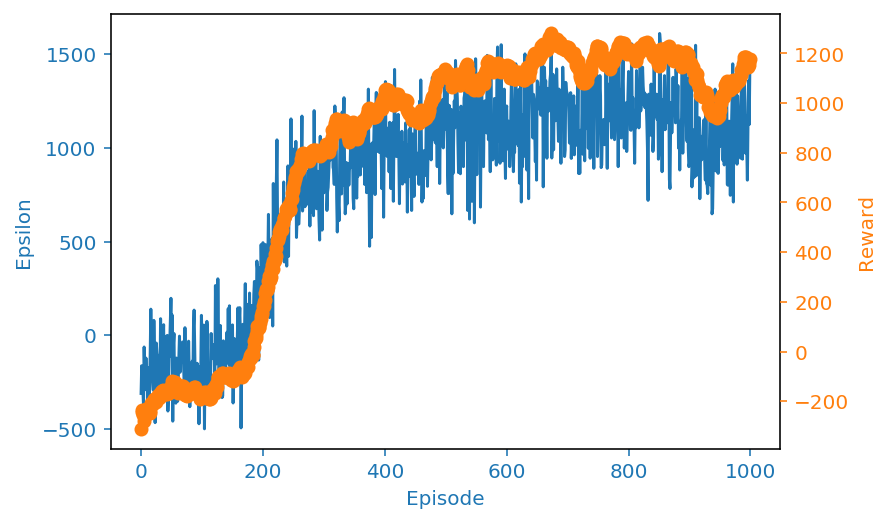

In [48]:
plot_learning_with_epsilon(list(range(len(total_rewards))),total_rewards,total_rewards,)

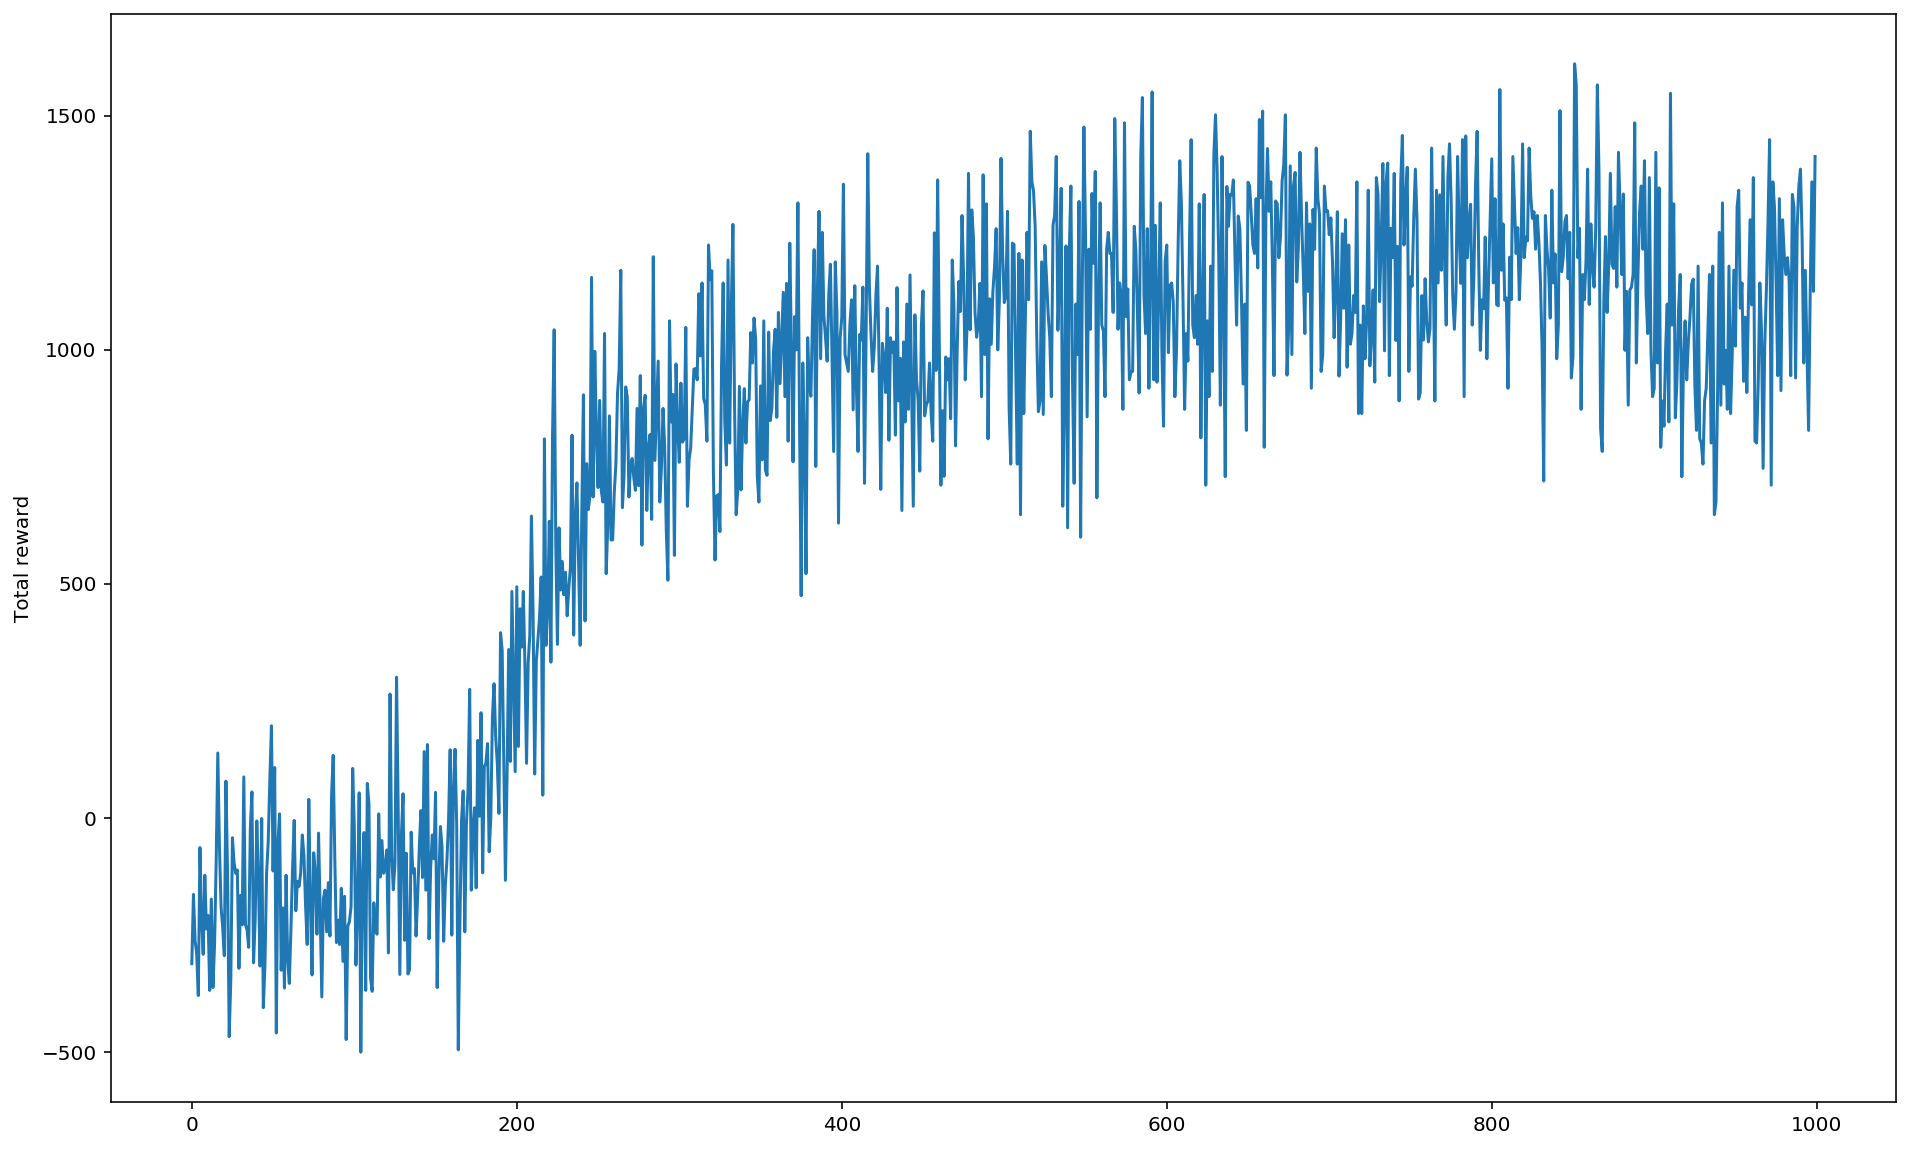

In [19]:
# Plotting total rewards
plt.figure(figsize=(16,10))
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

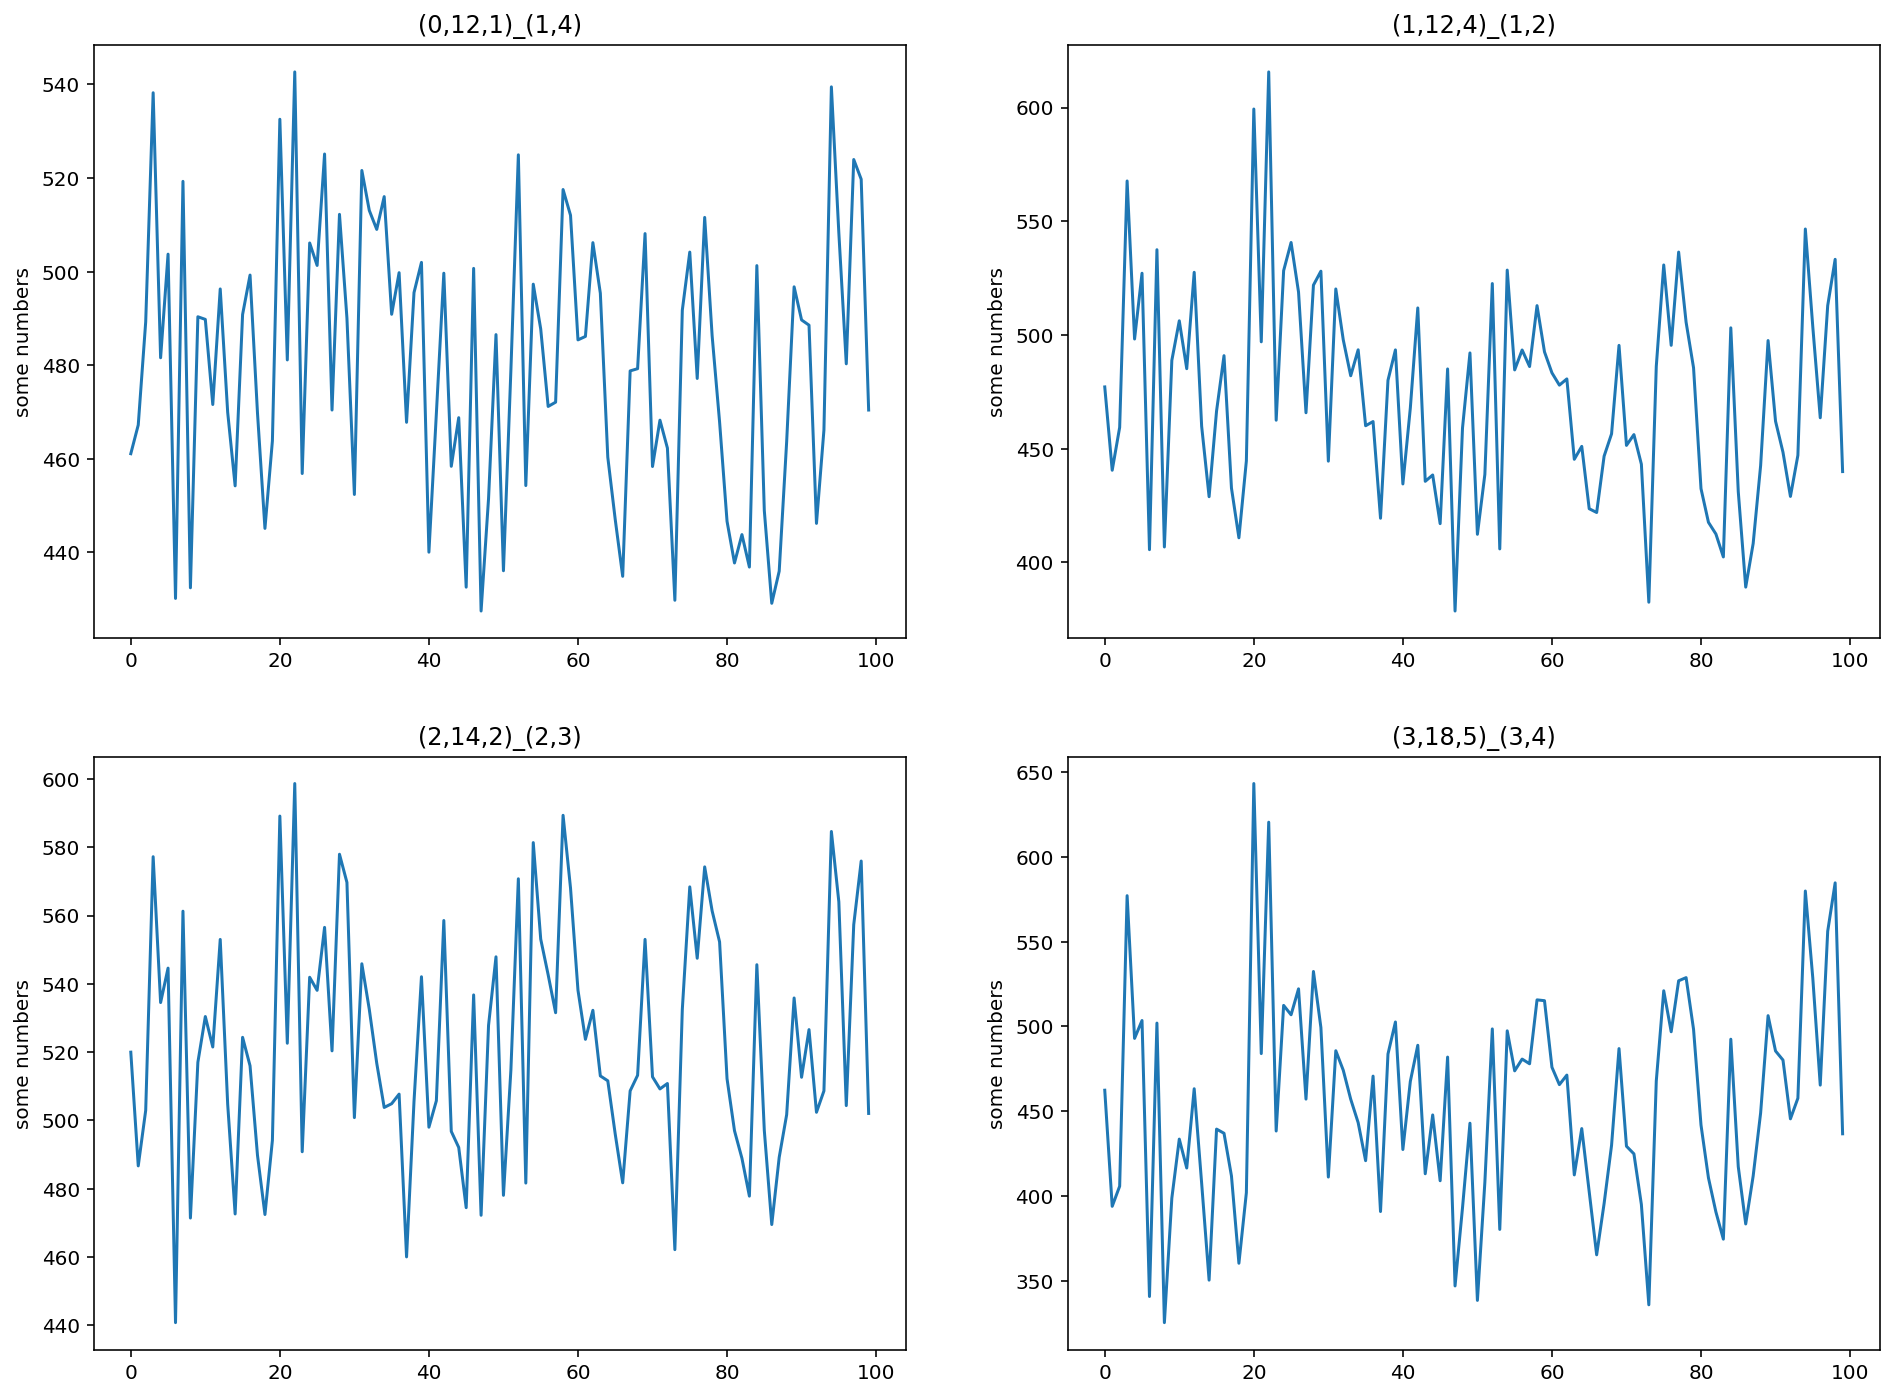

In [37]:
plot_tracked_values(agent.states_track, big=True, limit_values_from_last=100)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [21]:
epsilon_greedy_policy = EpsilonGreedyPolicy(
    epsilon_max=agent_param.epsilon_max,
    epsilon_min=agent_param.epsilon_min,
    epsilon_decay=agent_param.epsilon_decay)

time = np.arange(0, EPISODES)
epsilon = []
for i in range(0, EPISODES):
    epsilon.append(epsilon_greedy_policy.get_epsilon(i))

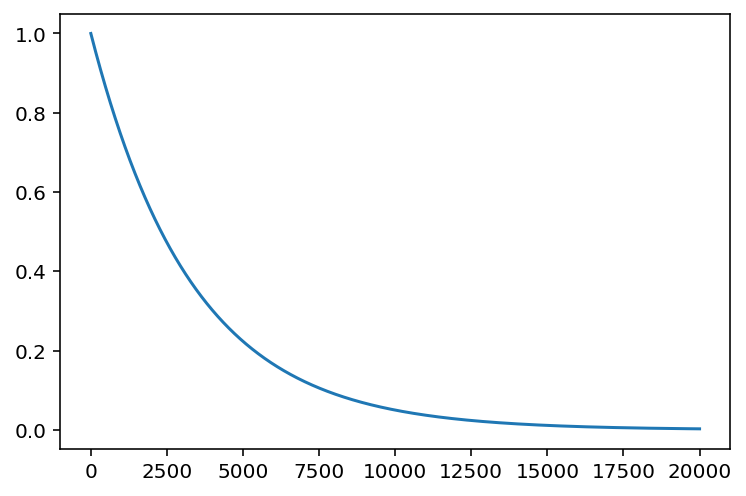

In [22]:
plt.plot(time, epsilon)
plt.show()